In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

In [90]:
class Environment:
    def __init__(self):
        self.n_actions = 3
        self.n_obs = 3
        self.max_steps = 100
        self.shape = (3,10)
        
    def reset(self):
        self.x = self.shape[1]
        self.state = []
        self.allocation = np.zeros(shape=(3,))
        self.allocation[0] = 1
        
        self.x_space = np.arange(self.max_steps)
        a0_space = np.zeros_like(np.linspace(0,1,self.max_steps))
        self.state.append(a0_space)
        current = [a0_space[self.x-self.shape[1]:self.x]]
        for i in range(1, self.shape[0]):
            a_c = np.random.randint(2,17)
            a_space = np.sin(np.linspace(0,a_c*np.pi,self.max_steps))
            self.state.append(a_space)
            current.append(a_space[self.x-self.shape[1]:self.x])
            
        return np.array(current)
    
    def step(self, allocation):
        self.allocation = allocation
        self.x += 1
        current = []
        reward = []
        for i in range(self.shape[0]):
            a_space = self.state[i][self.x-self.shape[1]:self.x]
            current.append(a_space)
            reward.append(a_space[-1]*allocation[i])
        
        #reward = allocation*current
        #reward[0] = 100*allocation[0]
            
        done = False
        if self.x >= self.max_steps - 1:
            done = True
            
        return np.array(current), reward, done, {}
    
    def get_render_data(self):
        return self.x_data, self.a0_data, self.a1_data, self.a2_data, self.allocation
    
    def render(self):
        #x_data, a0_data, a1_data, a2_data, alloc_data = self.get_render_data()
        fig, ax = plt.subplots(1,2,figsize=(12,6),gridspec_kw = {'width_ratios':[2, 1]})

        for i in range(self.shape[0]):
            a_space = self.state[i]
            ax[0].plot(self.x_space, a_space, label=str(i))
            
        ax[0].legend(loc='upper left')
        ax[0].plot([self.x, self.x], [-0.1,0.1], 'k')
        ax[1].set_ylim(0,1)
        ax[1].bar([0,1,2], self.allocation)

        plt.show()

s0 (3, 10)
s (3, 10)
r [0.0, 0.19997482553477502, -0.41628492731738587]
d False


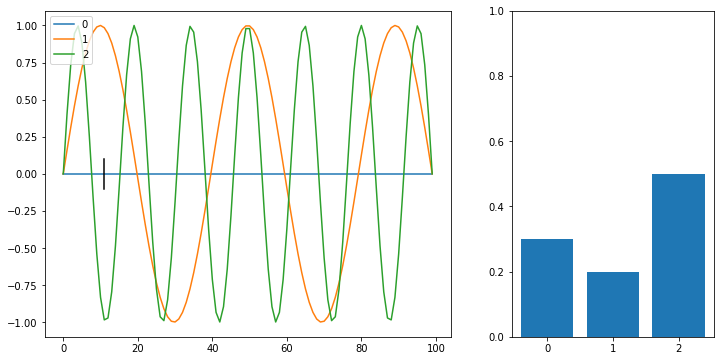

In [92]:
env = Environment()
s0 = env.reset()
print('s0', s0.shape)
s, r, d, i = env.step(np.array([0.3, 0.2, 0.5]))
print('s',s.shape)
print('r',r)
print('d',d)
env.render()

In [73]:
class Environment:
    def __init__(self):
        self.n_actions = 3
        self.n_obs = 3
        self.max_steps = 100
        self.shape = (3,10)
        
    def reset(self):
        self.x = self.shape[1]
        self.state = []
        
        self.x_space = np.arange(self.max_steps)
        a0_space = np.zeros_like(np.linspace(0,1,self.max_steps))
        self.state.append(a0_space)
        current = [a0_space[self.x-self.shape[1]:self.x]]
        for i in range(1, self.shape[0]):
            a_c = np.random.randint(2,17)
            a_space = np.sin(np.linspace(0,a_c*np.pi,self.max_steps))
            self.state.append(a_space)
            current.append(a_space[self.x-self.shape[1]:self.x])
            
        return np.array(current)
    
    def step(self, allocation):
        self.allocation = allocation
        self.x += 1
        current = []
        reward = []
        for i in range(self.shape[0]):
            a_space = self.state[i][self.x-self.shape[1]:self.x]
            current.append(a_space[self.x-self.shape[1]:self.x])
            reward.append(allocation[i]*a_space[-1])
        
        #reward = allocation*current
        #reward[0] = 100*allocation[0]
            
        done = False
        if self.x >= self.max_steps - 1:
            done = True
            
        return np.array(self.state), reward, done, {}
    
    def get_render_data(self):
        return self.x_data, self.a0_data, self.a1_data, self.a2_data, self.allocation
    
    def render(self):
        #x_data, a0_data, a1_data, a2_data, alloc_data = self.get_render_data()
        fig, ax = plt.subplots(1,2,figsize=(12,6),gridspec_kw = {'width_ratios':[2, 1]})

        for i in range(self.shape[0]):
            a_space = self.state[i]
            ax[0].plot(x_data, a_space, label=str(i))
            
        ax[0].legend(loc='upper left')
        ax[0].plot([self.x, self.x], [-0.1,0.1], 'k')
        ax[1].set_ylim(0,1)
        ax[1].bar([0,1,2], self.allocation)

        plt.show()

In [80]:
class Agent:
    def __init__(self, n_obs, n_actions,
                epsilon=0.2, gamma=0.99, entropy_loss=1e-3, actor_lr=0.001, critic_lr=0.005,
                hidden_size=128, epochs=10, batch_size=64, buffer_size=256):
        # Clear Tensorflow session and set some metadata
        K.clear_session()
        self.n_obs = n_obs
        self.n_actions = n_actions
        self.obs_shape = None
        
        # Set hyperparameters
        self.epsilon = epsilon
        self.gamma = gamma
        self.entropy_loss = entropy_loss
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        
        # Build Actor and Critic models
        self.actor = self.build_actor() 
        self.critic = self.build_critic()
        
        # When we want predictions of actions, we need to pass in three things:
        # the observation, the old prob, and the advantage.
        # Here, we just created data to spoof the last two.
        self.DUMMY_ACTION, self.DUMMY_VALUE = np.zeros((1, self.n_actions)), np.zeros((1, self.n_obs))

    def proximal_policy_optimization_loss(self, advantage, old_alloc, debug=True):
        def loss(y_true, y_pred):
            y_pred = K.print_tensor(y_pred, 'pred ')
            return -advantage*y_pred
        return loss
    
    def build_actor(self):
        # actor has three inputs: the current state, the advantage,
        # and the agent's predicted probability for the given observation
        state_inputs = Input(shape=(self.n_obs, 10))
        advantage = Input(shape=(self.n_obs,))
        old_alloc = Input(shape=(self.n_actions,))
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # the output is a probability distribution over the actions
        out_actions = Dense(self.n_actions, activation='softmax')(x)

        model = Model(inputs=[state_inputs, advantage, old_alloc],
                      outputs=[out_actions])
        
        # compile the model using our custom loss function
        model.compile(optimizer=Adam(lr=self.actor_lr),
                      loss=[self.proximal_policy_optimization_loss(
                          advantage=advantage,
                          old_alloc=old_alloc
                      )])
        return model
    
    def build_critic(self):
        # critic recieves the observation as input
        state_inputs = Input(shape=(self.n_obs, 10))
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # we predict the value of the current observation
        # i.e., cumulative discounted reward
        predictions = Dense(self.n_obs, activation='linear')(x)

        model = Model(inputs=state_inputs, outputs=predictions)
        model.compile(optimizer=Adam(lr=self.critic_lr),
                      loss='mse')
        return model

    def get_allocation(self, observation):
        alloc = self.actor.predict([[observation], 
                                   self.DUMMY_VALUE, 
                                   self.DUMMY_ACTION])
        alloc = alloc.flatten()
        return alloc
    
    def train_batch(self, observations, allocations, rewards):
        # limit our data to the buffer_size
        obs = observations[:self.buffer_size]
        allocs = allocations[:self.buffer_size]
        rews = rewards[:self.buffer_size]
        
        # our 'old probs' are really just the batches probs
        old_allocs = allocs
        
        # Calculate advantages
        values = self.critic.predict(obs)
        advs = rews - values
            
        # Train the actor and critic on the batch data
        self.actor.fit([obs, rews, old_allocs], [allocs],
                       batch_size=self.batch_size, shuffle=True,
                       epochs=self.epochs, verbose=False)
        self.critic.fit([obs], [rews],
                       batch_size=self.batch_size, shuffle=True,
                        epochs=self.epochs, verbose=False)
    
    def run(self, env, episodes, verbose=False, test_run=False):
        episode = 0
        reward_history = []
        end_test=False
        self.obs_shape = env.shape

        # reset the environment
        observation = env.reset()

        # Collect a batch of samples
        while episode < episodes:
            # 'Master Batch' that we add mini batches to
            batch = {
                'observation': [],
                'allocation_vector': [],
                'reward': []
            }

            # Mini batch which contains a single episode's data
            tmp_batch = {
                'observation': [],
                'allocation_vector': [],
                'reward': []
            }

            # While we don't hit the buffer size with our master batch...
            while len(batch['observation']) < self.buffer_size and not end_test:
                # Get the action (scalar), action vector (one-hot vector), 
                # and probability distribution (vector) from the current observation
                alloc_vector = self.get_allocation(observation)

                # Get the next observation, reward, done, and info for taking an action
                next_observation, reward, done, info = env.step(alloc_vector)

                # Append the data to the mini batch
                tmp_batch['observation'].append(observation)
                tmp_batch['allocation_vector'].append(alloc_vector)
                tmp_batch['reward'].append(reward)

                # The current observation is now the 'next' observation
                observation = next_observation
                
                if test_run:
                    env.render()

                # if the episode is at a terminal state...
                if done:
                    # log some reward data (for plotting)
                    reward_data = np.sum(tmp_batch['reward'])
                    reward_history.append(reward_data)

                    # transform rewards based to discounted cumulative rewards
                    # for j in range(len(tmp_batch['reward']) - 2, -1, -1):
                    #     tmp_batch['reward'][j] += tmp_batch['reward'][j + 1] * self.gamma

                    # for each entry in the mini batch...
                    for i in range(len(tmp_batch['observation'])):
                        # we unpack the data
                        obs = tmp_batch['observation'][i]
                        alloc = tmp_batch['allocation_vector'][i]
                        r = tmp_batch['reward'][i]

                        # and pack it into the master batch
                        batch['observation'].append(obs)
                        batch['allocation_vector'].append(alloc)
                        batch['reward'].append(r)

                    # if we're using my custom environment,
                    # we record some more data for plotting
                    try:
                        x_data, a0_data, a1_data, a2_data, alloc_data = env.get_render_data()
                    except:
                        pass

                    # reset the environment
                    observation = env.reset()

                    # reset the mini batch
                    tmp_batch = {
                        'observation': [],
                        'allocation_vector': [],
                        'reward': []
                    }

                    # increment the episode count
                    episode += 1
                    if test_run:
                        end_test = True

            if test_run:
                break
                
            # we've filled up our master batch, so we unpack it into numpy arrays
            observations = np.array(batch['observation'])
            actions = np.array(batch['allocation_vector'])
            rewards = np.array(batch['reward'])    
            #rewards = np.reshape(rewards, (len(batch['reward']), 1))

            # train the agent on the batched data
            self.train_batch(observations, actions, rewards)

            # every 10th episode, log some stuff
            if (episode % 10 == 0 or episode == episodes - 1):
                print('Episode:', episode)
                print('Reward :', reward_data)
                print('Average:', np.mean(reward_history[-100:]))
                print('-'*10)
                print()
                
                fig, ax = plt.subplots(1,2,figsize=(12,6),gridspec_kw = {'width_ratios':[2, 1]})

                ax[0].plot(x_data, a0_data, label='0')
                ax[0].plot(x_data, a1_data, label='1')
                ax[0].plot(x_data, a2_data, label='2')
                ax[0].legend(loc='upper left')
                ax[1].set_ylim(0,1)
                ax[1].bar([0,1,2], alloc_data)

                plt.show()
                    
        self.reward_history = reward_history
        return self.reward_history

In [81]:
env = Environment()
NUM_OBS = env.n_obs
NUM_ACTS = env.n_actions

agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)
rh = agent.run(env, 1000, verbose=False)

ValueError: Error when checking input: expected input_1 to have shape (3, 10) but got array with shape (3, 100)

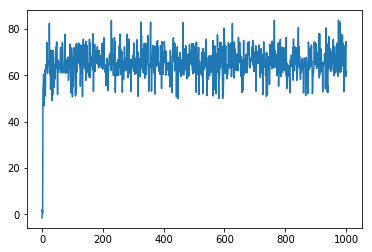

In [60]:
plt.plot(rh)
plt.show()

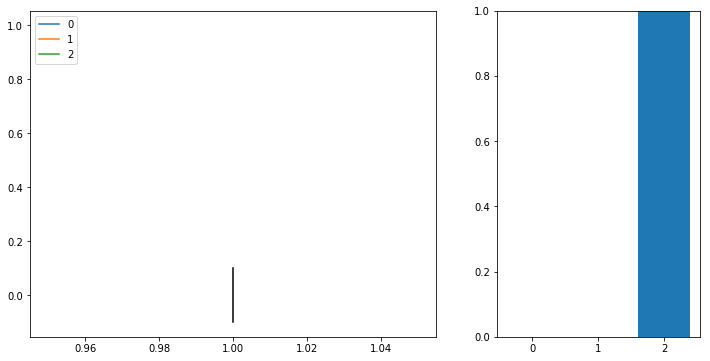

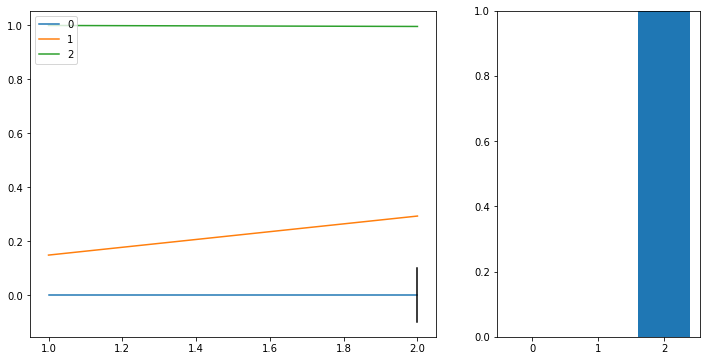

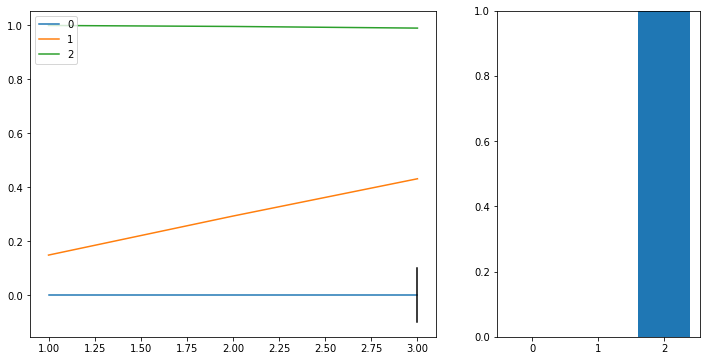

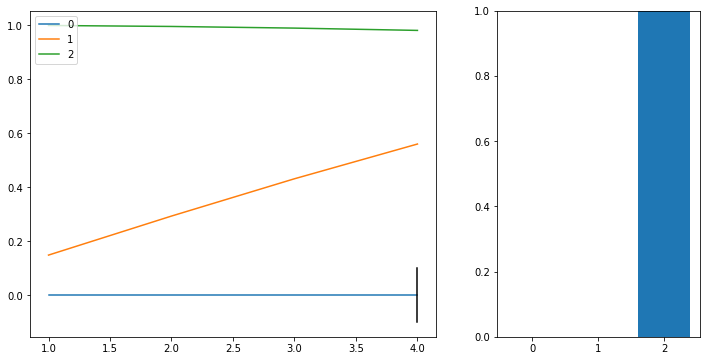

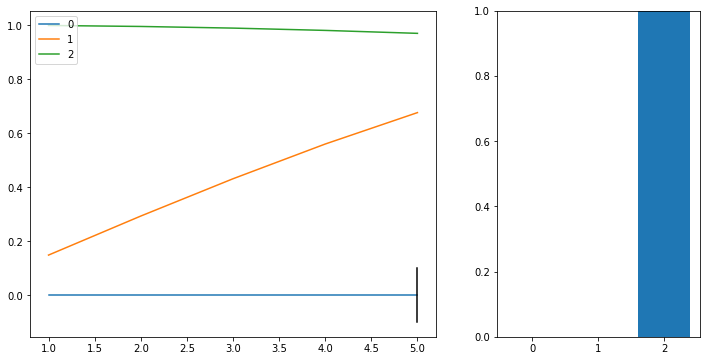

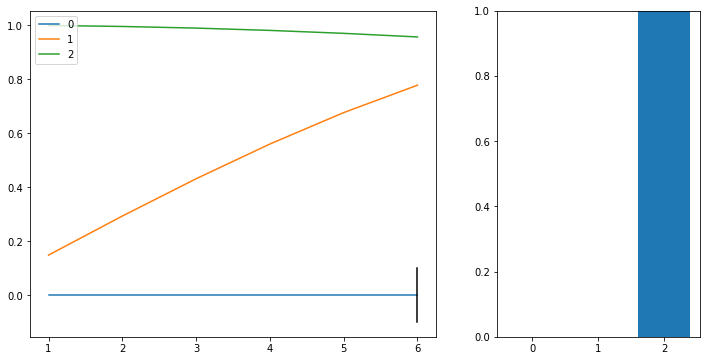

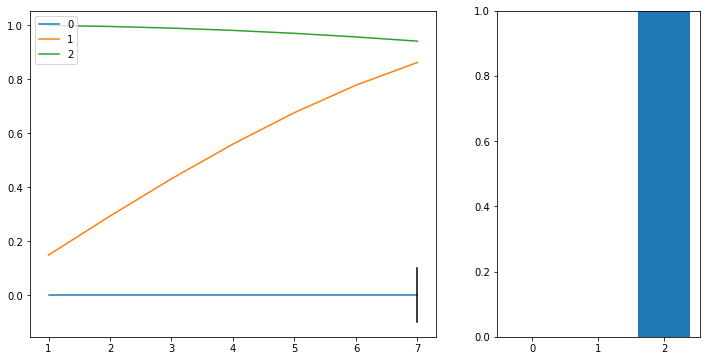

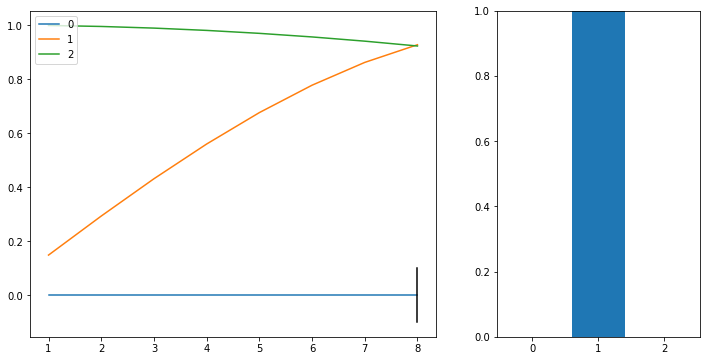

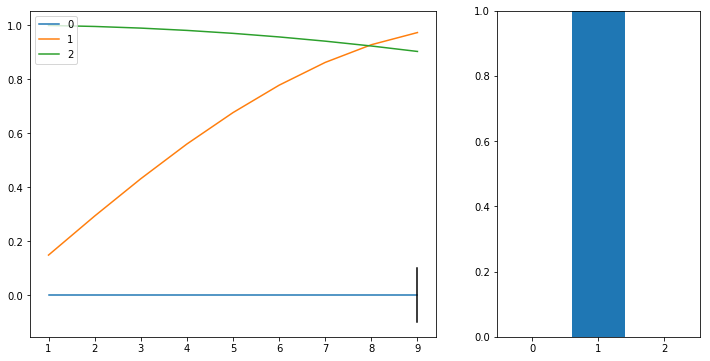

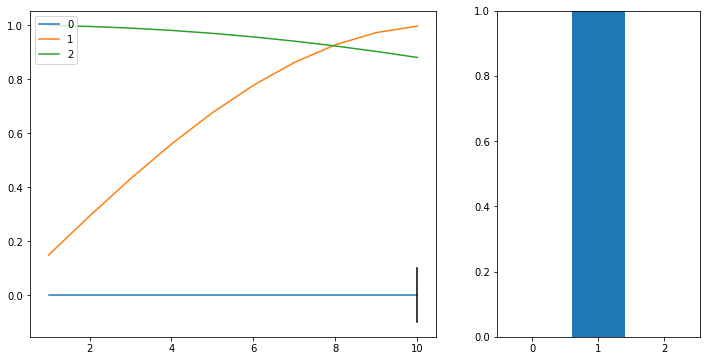

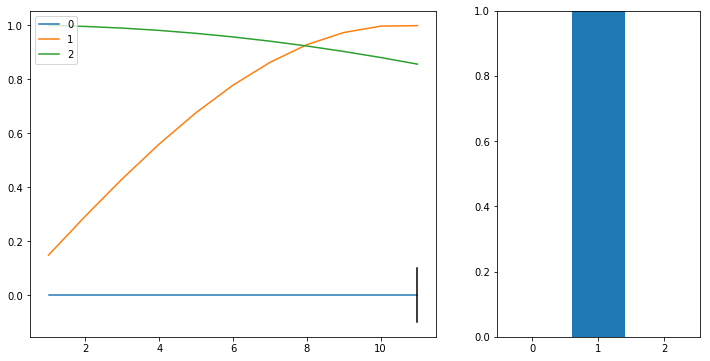

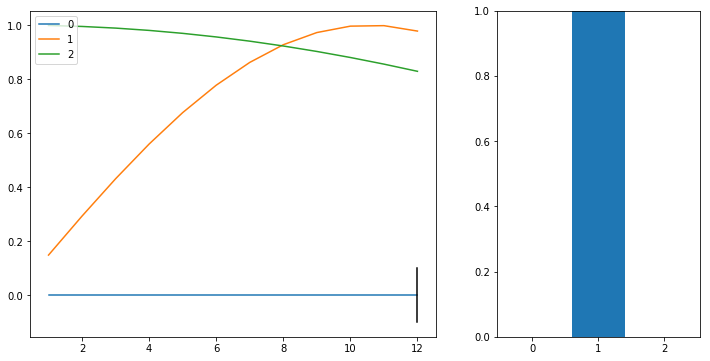

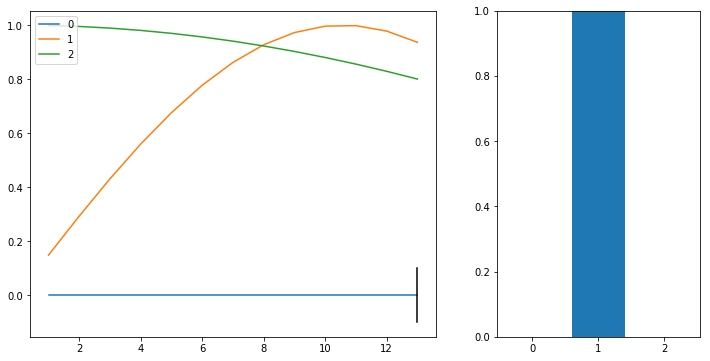

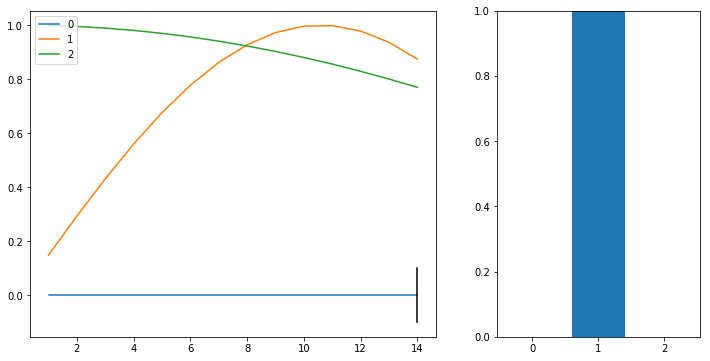

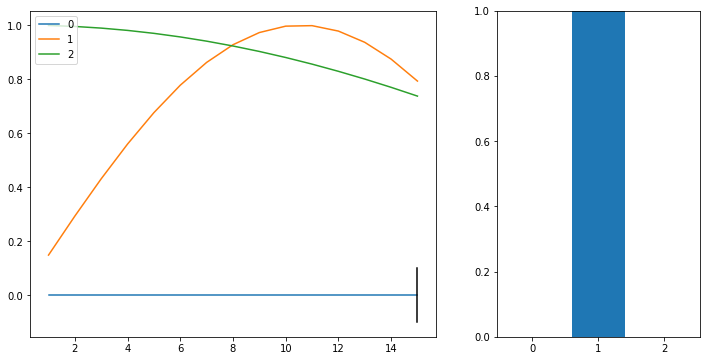

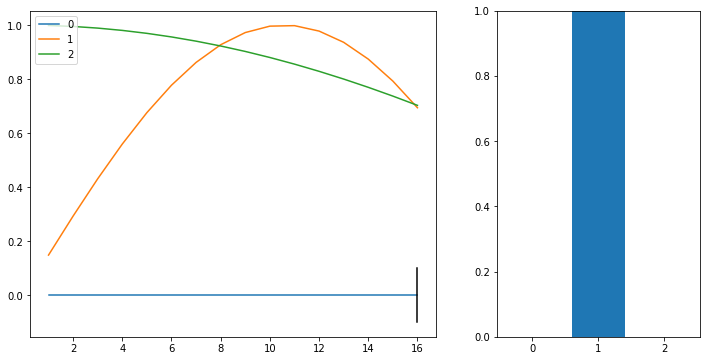

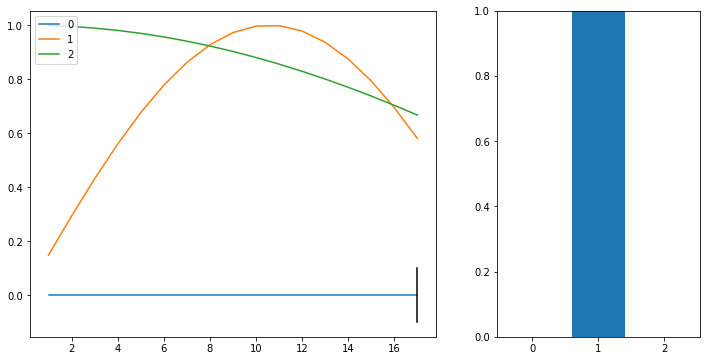

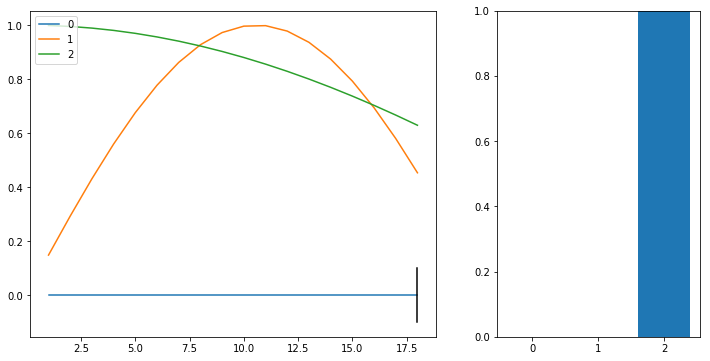

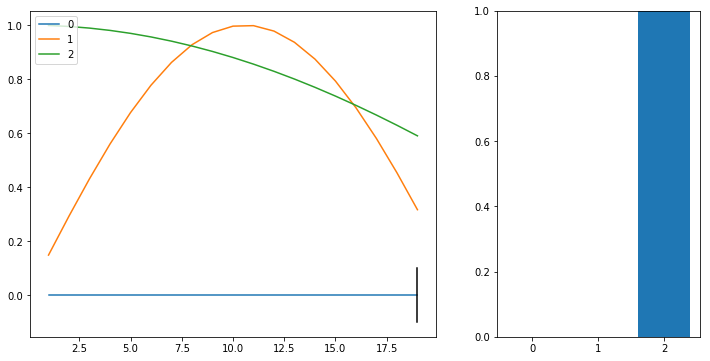

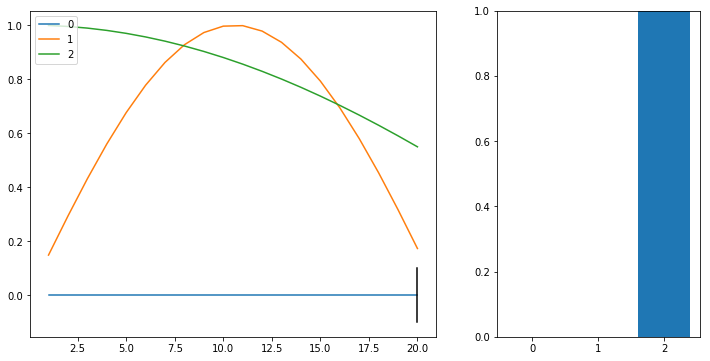

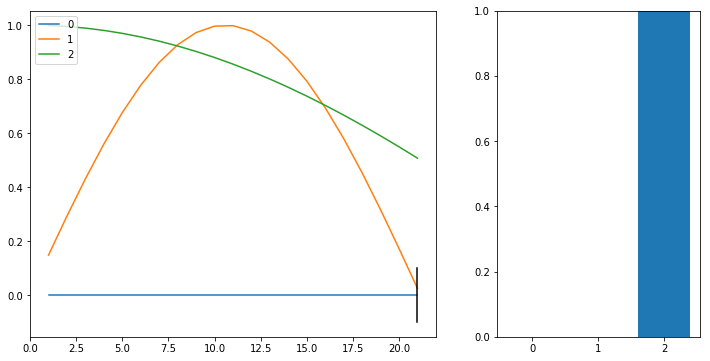

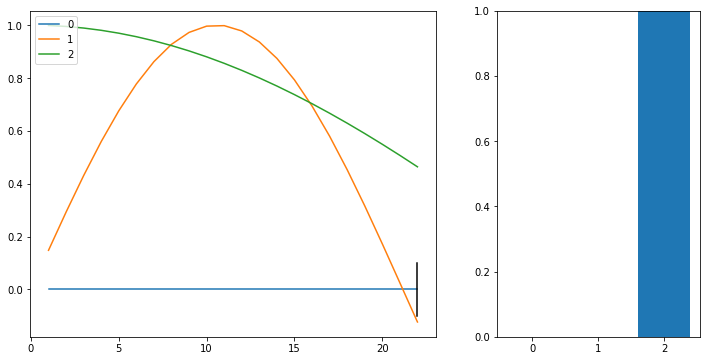

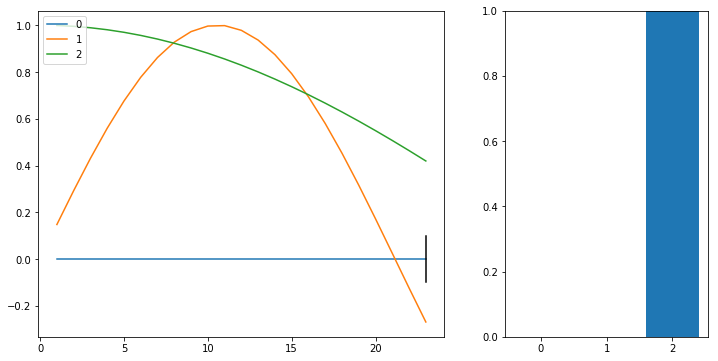

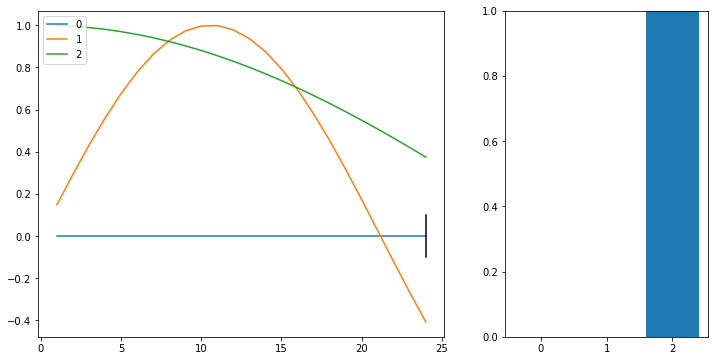

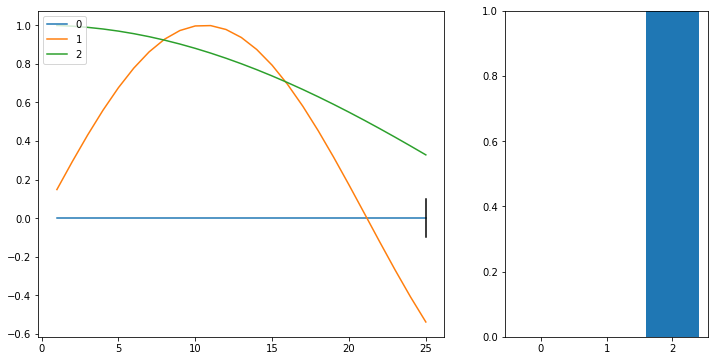

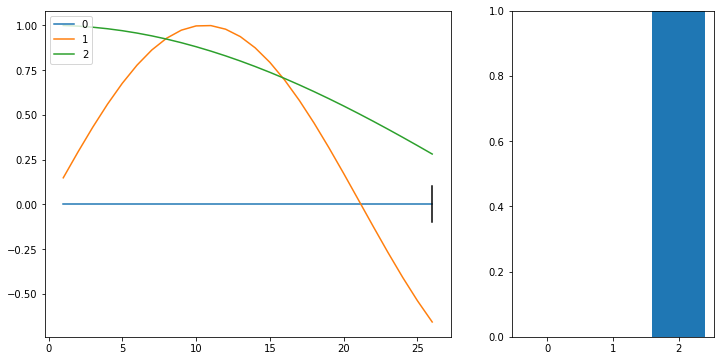

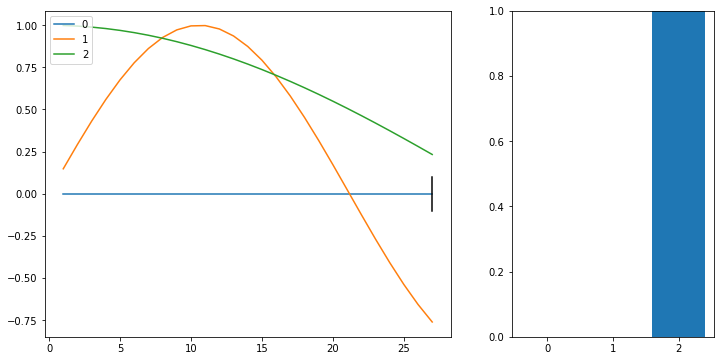

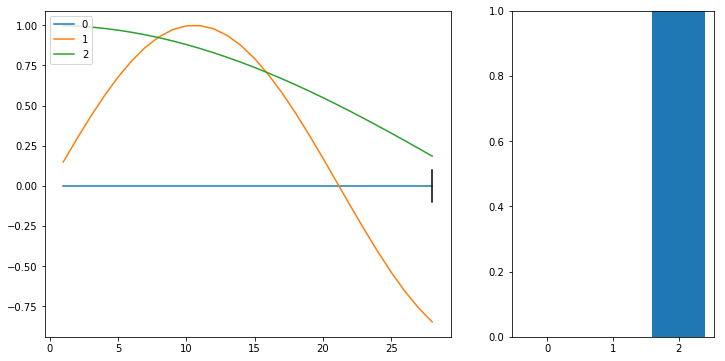

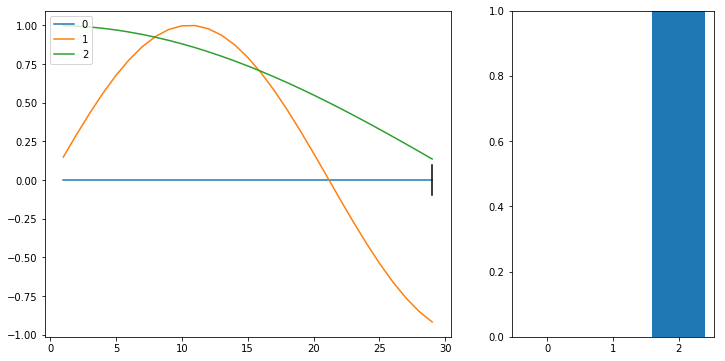

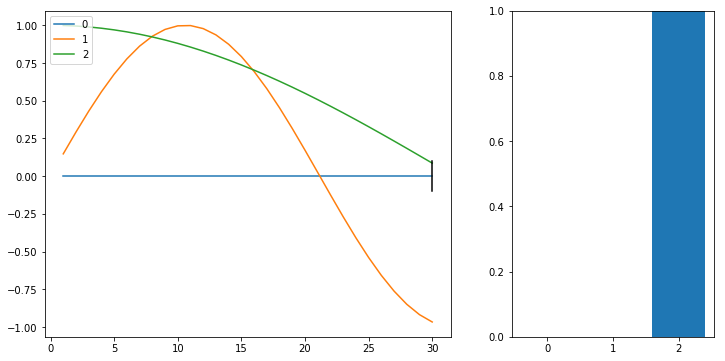

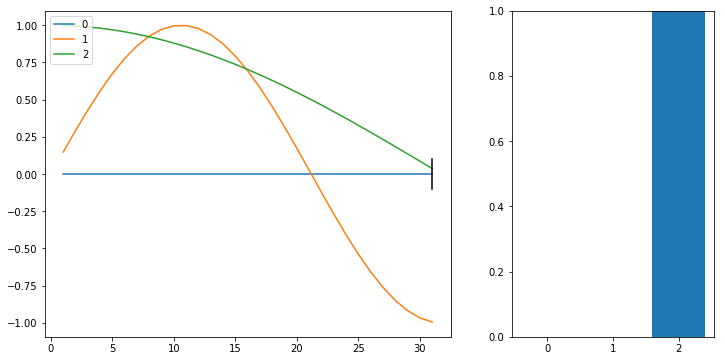

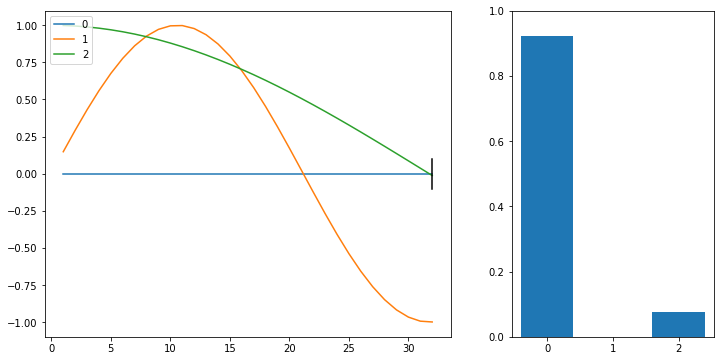

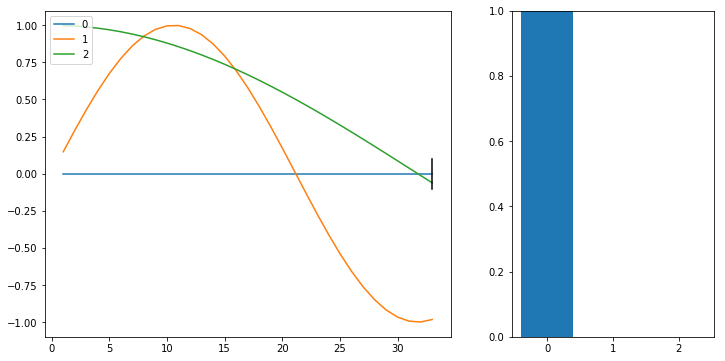

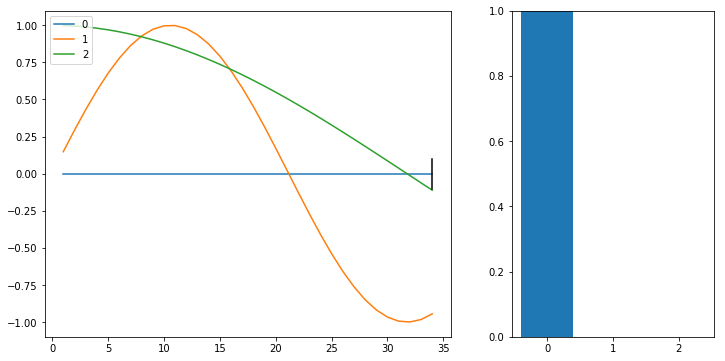

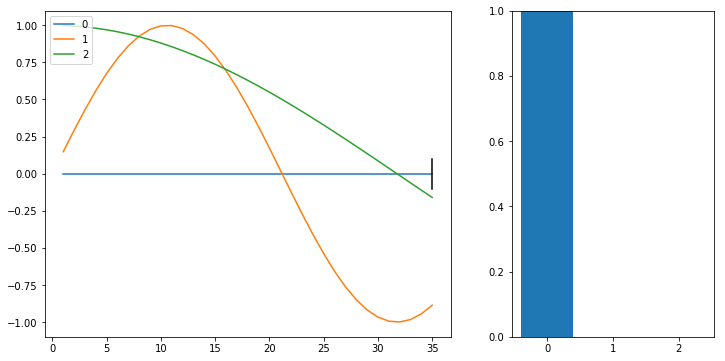

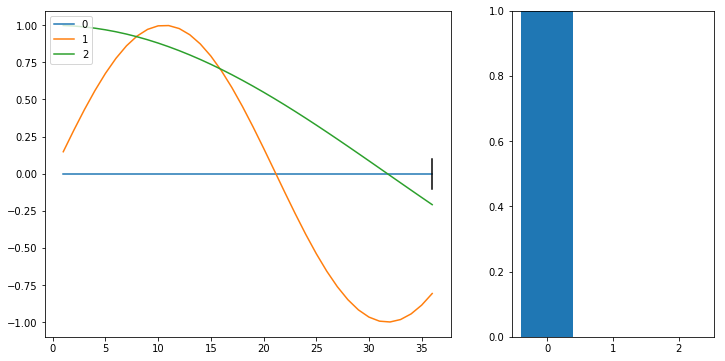

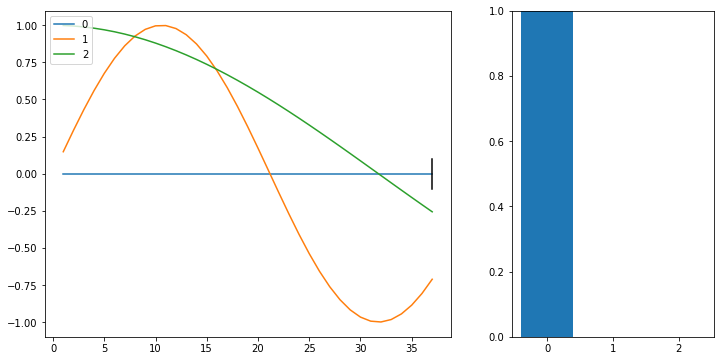

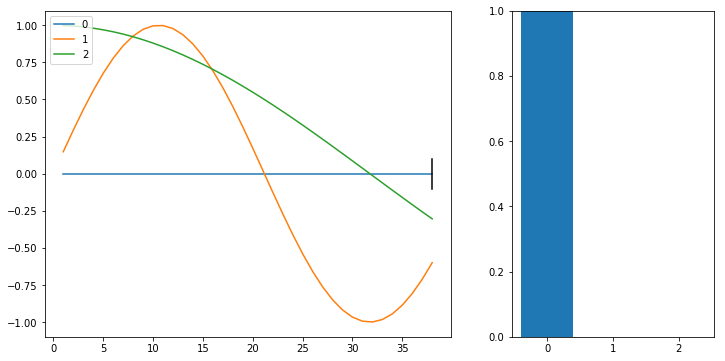

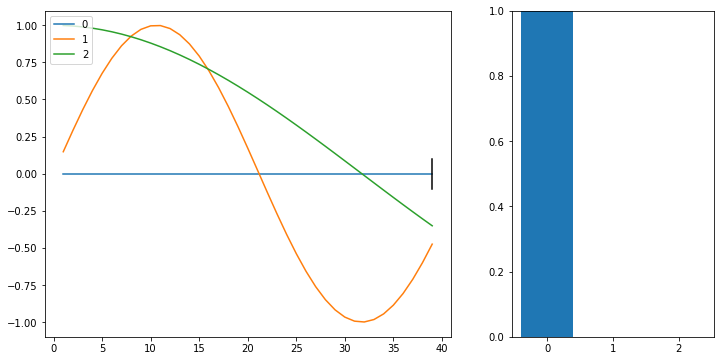

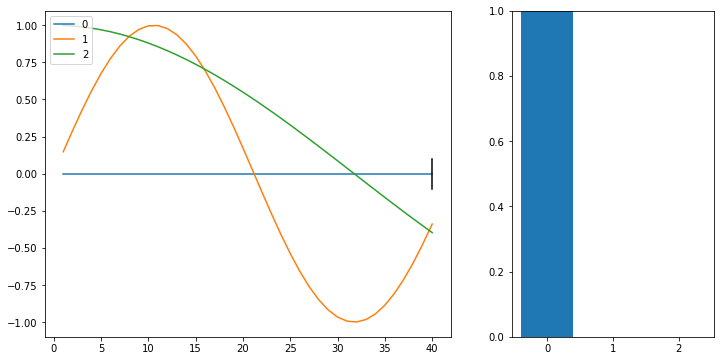

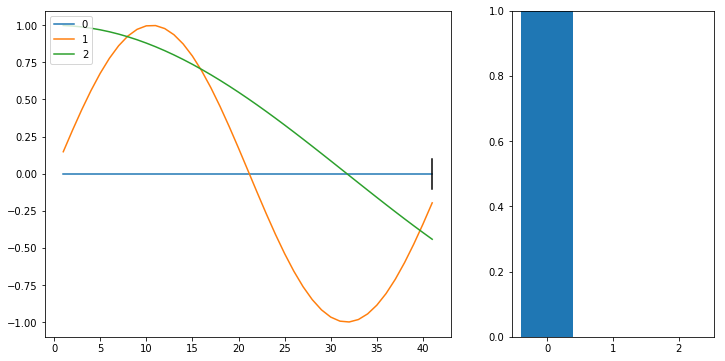

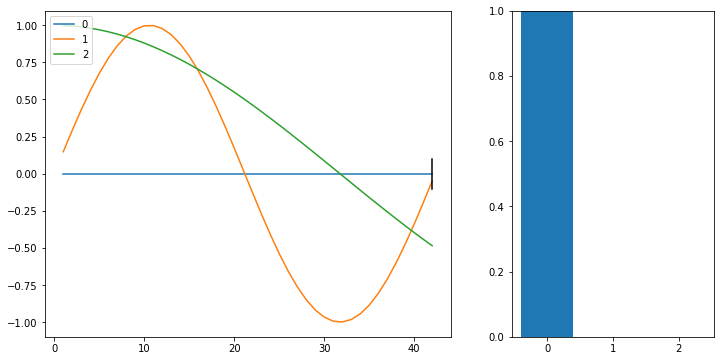

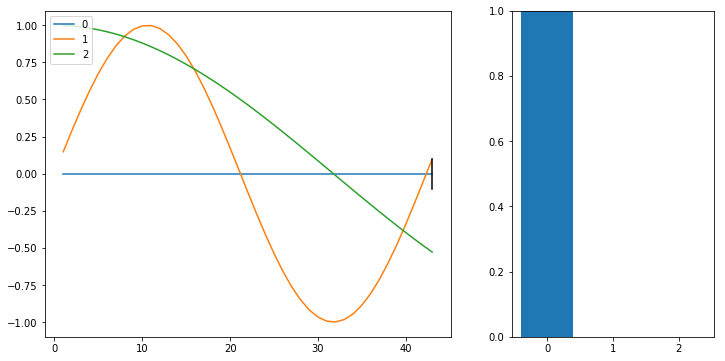

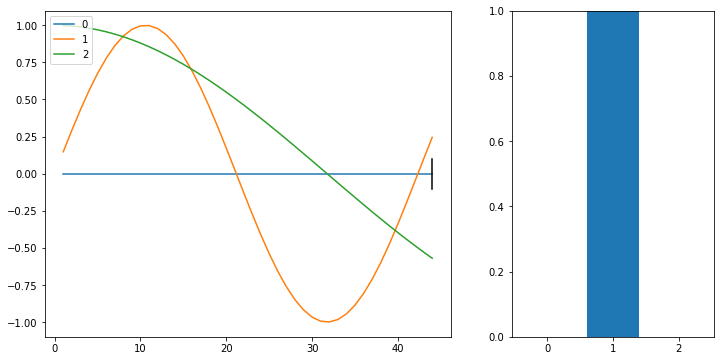

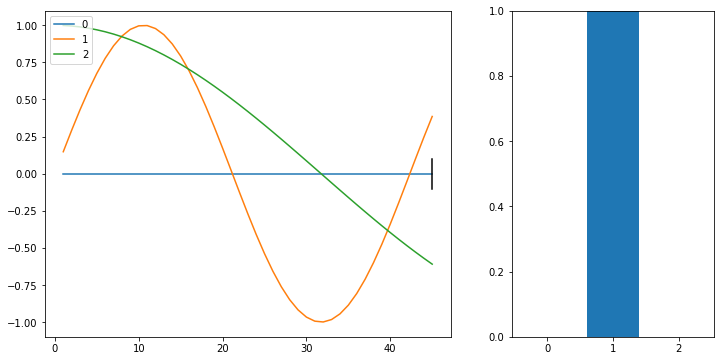

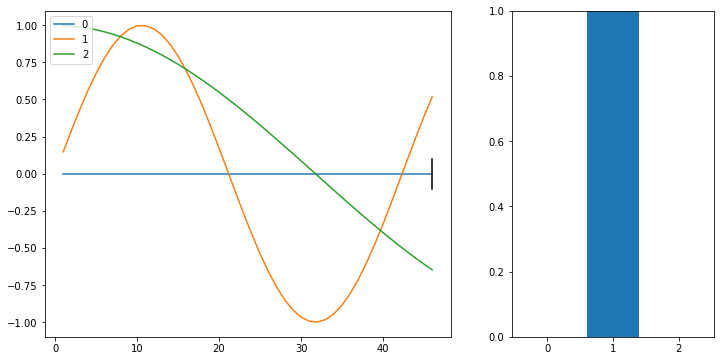

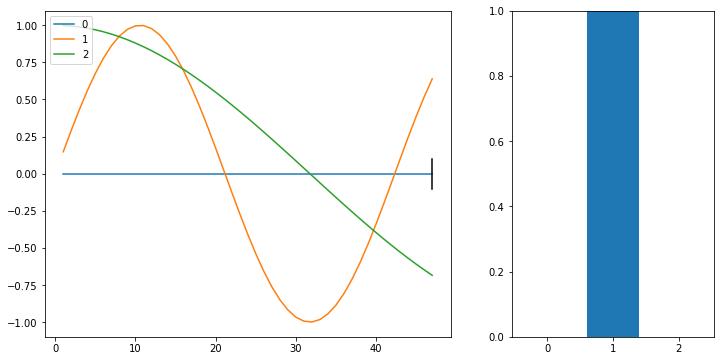

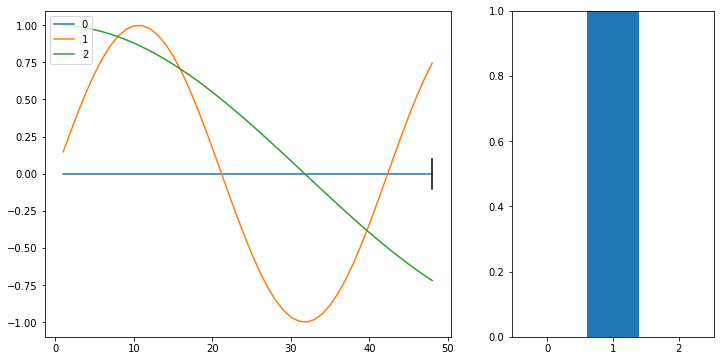

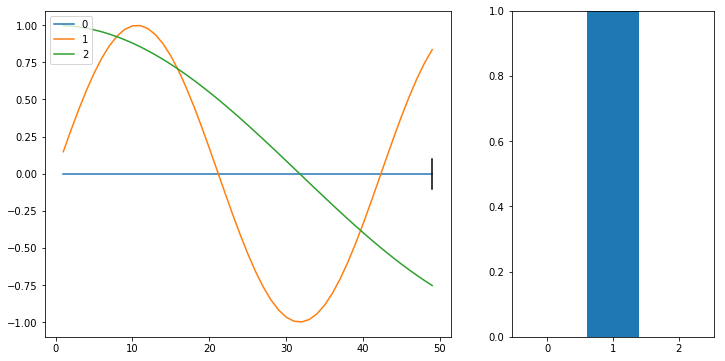

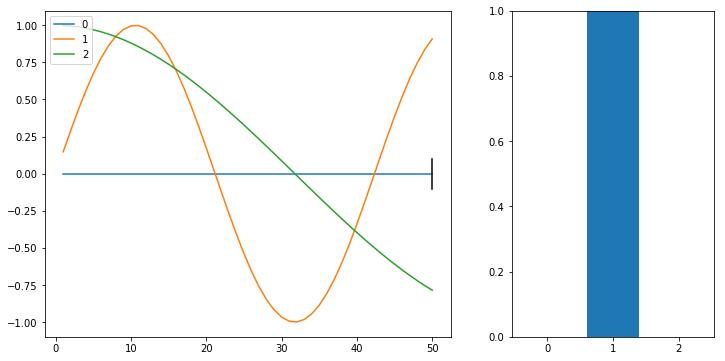

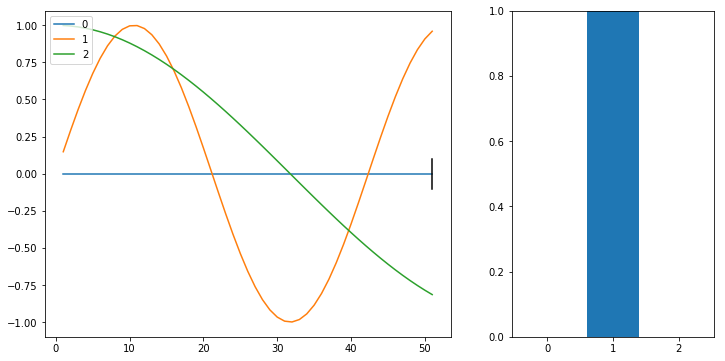

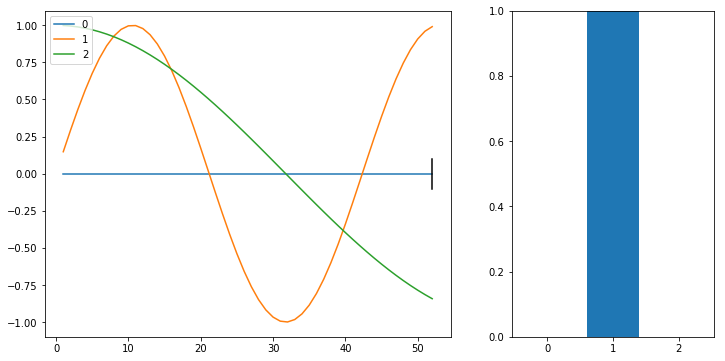

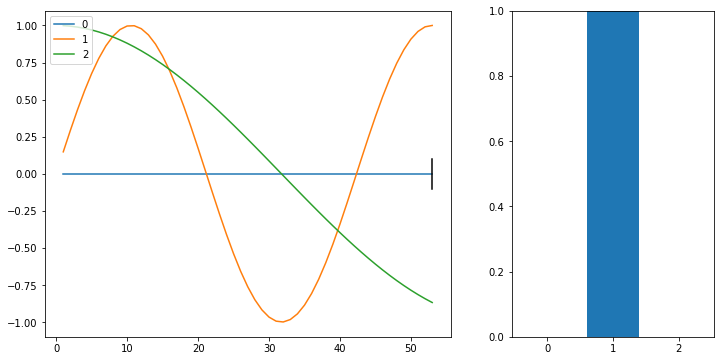

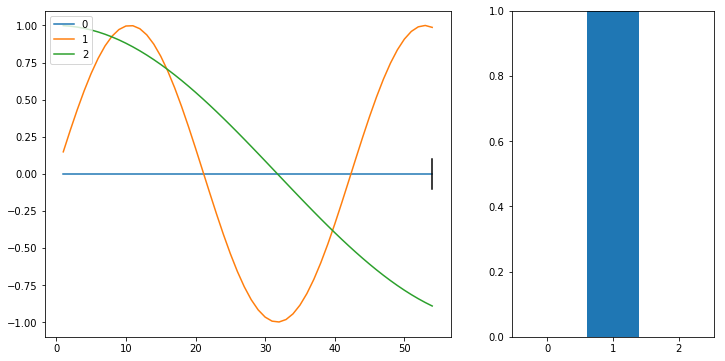

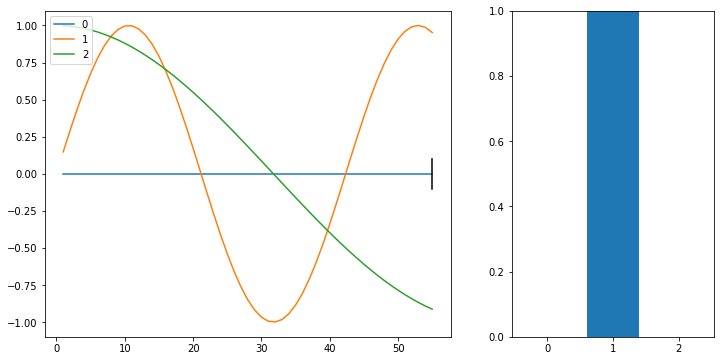

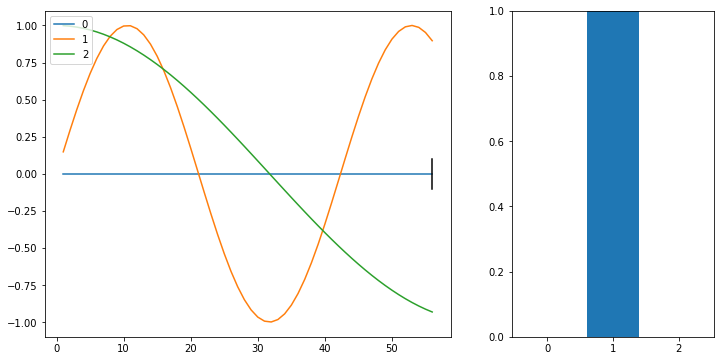

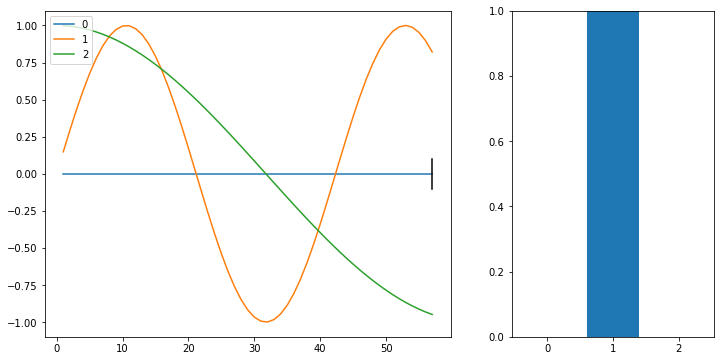

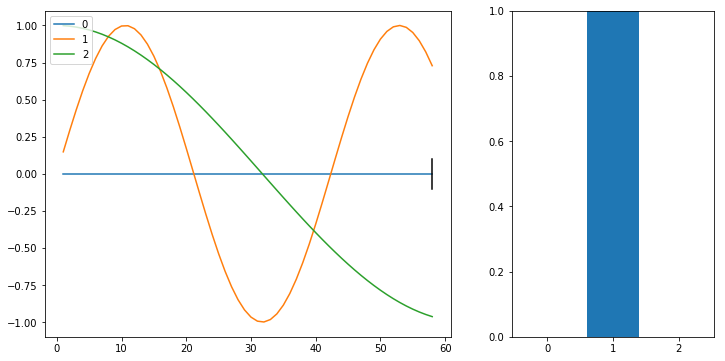

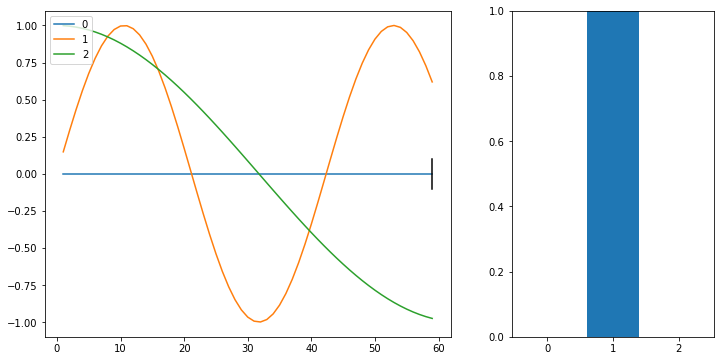

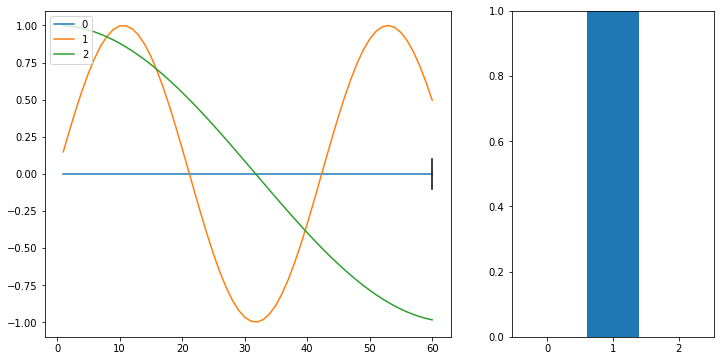

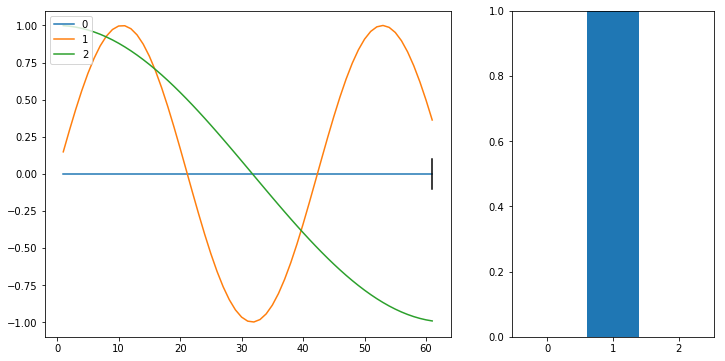

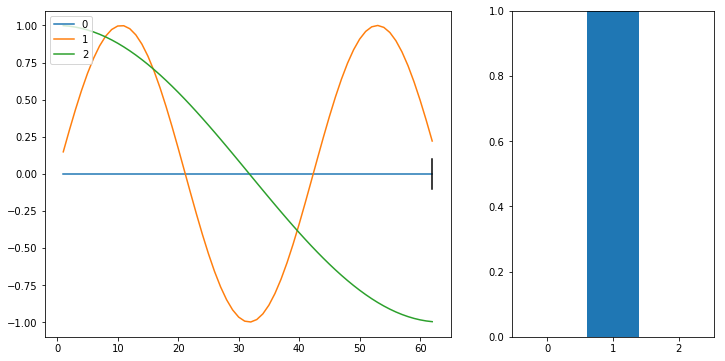

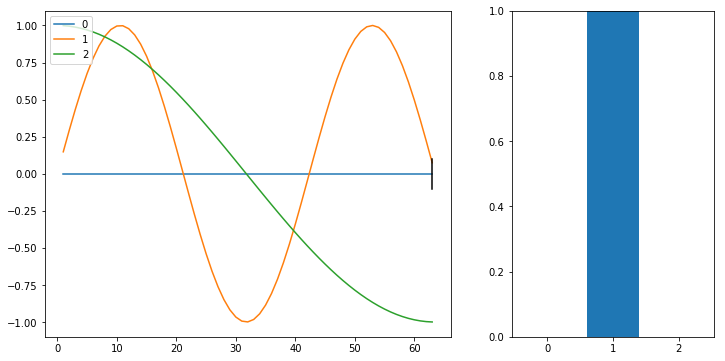

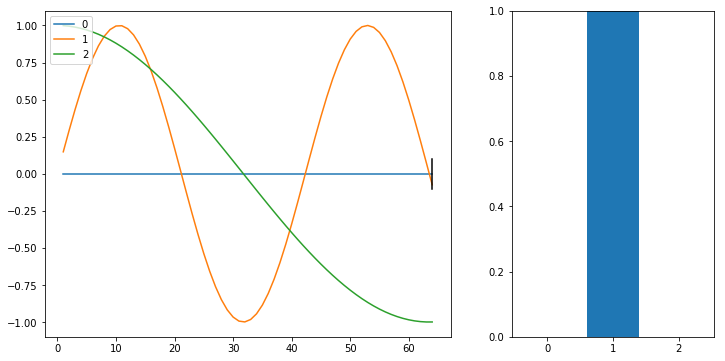

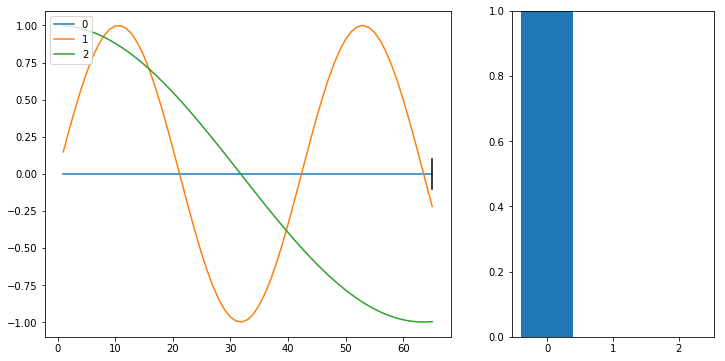

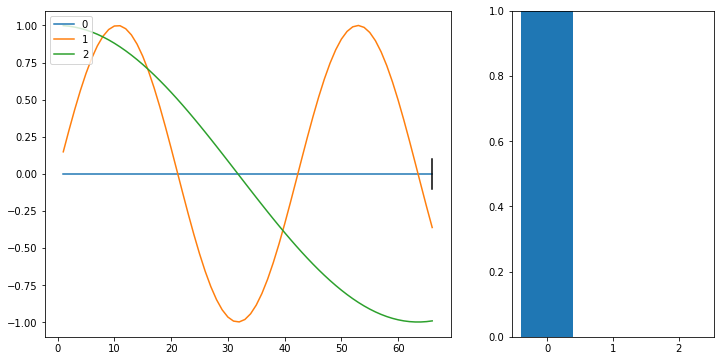

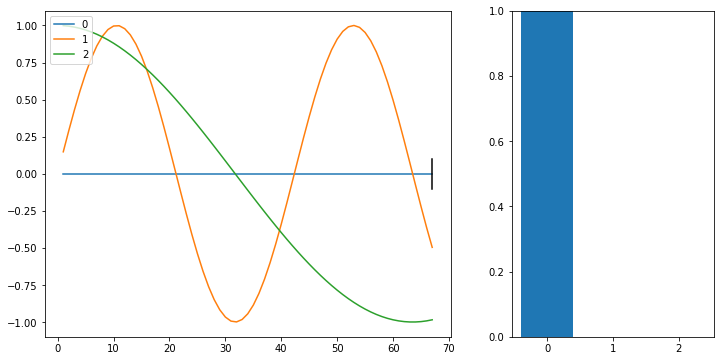

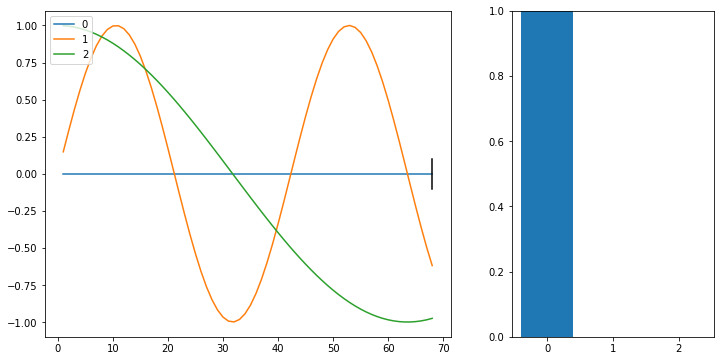

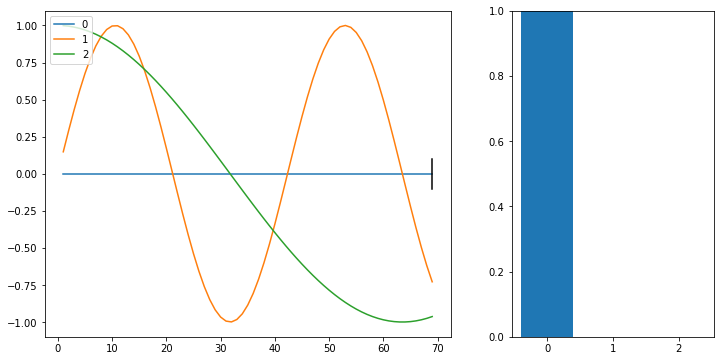

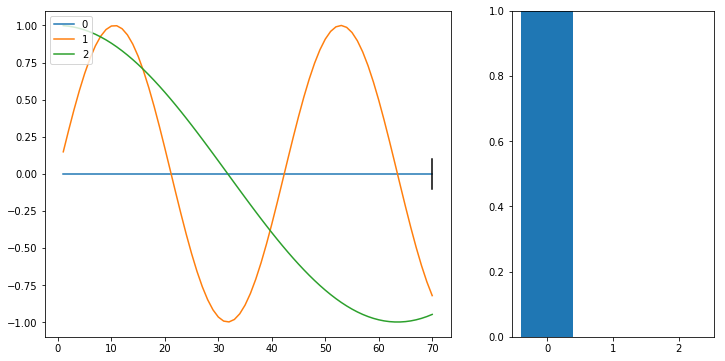

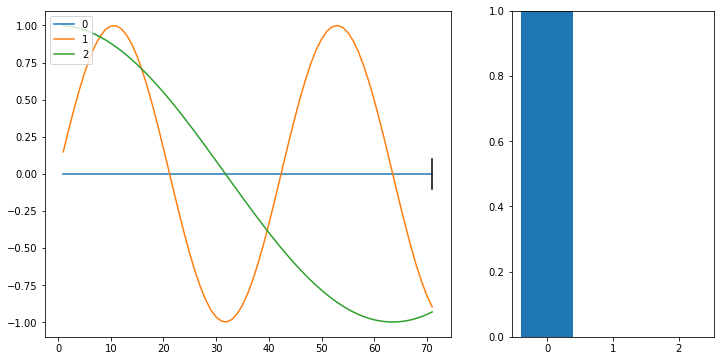

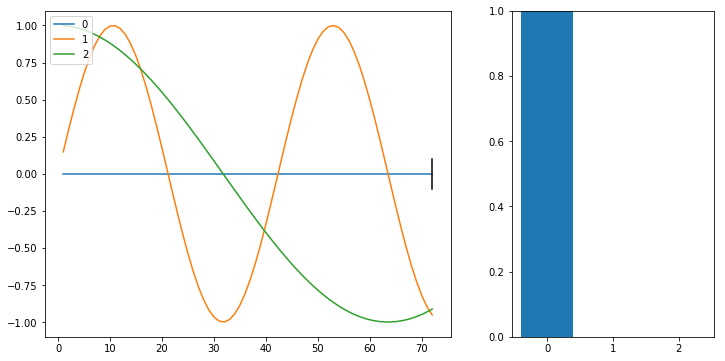

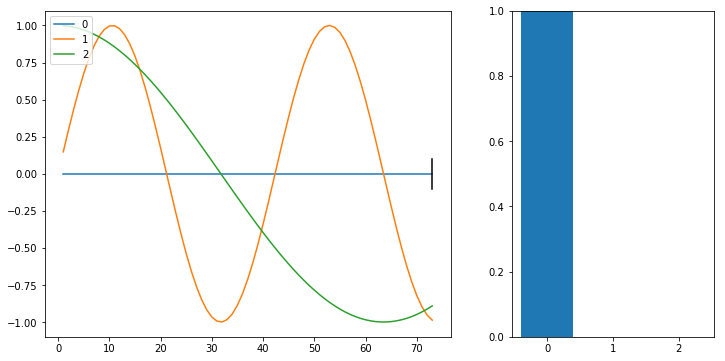

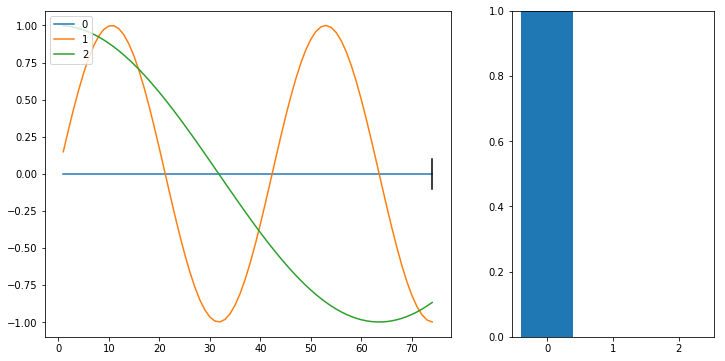

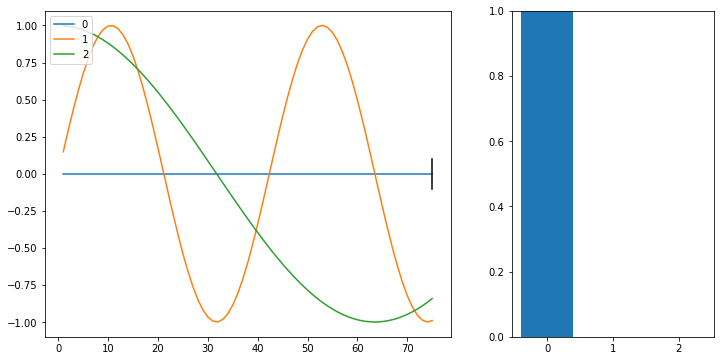

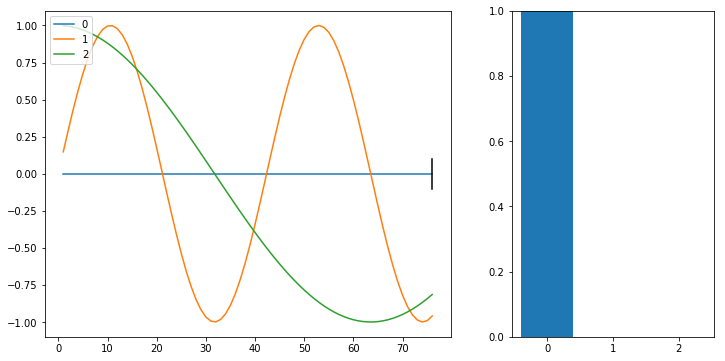

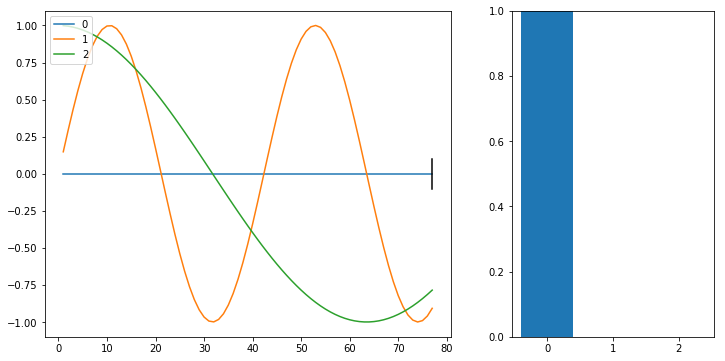

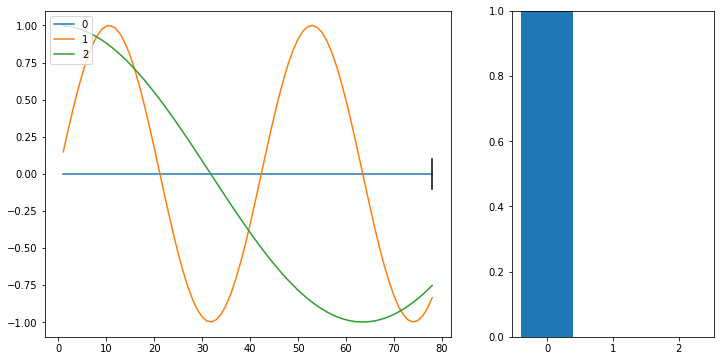

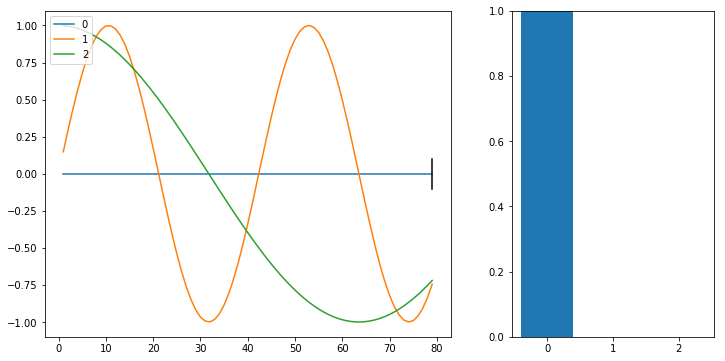

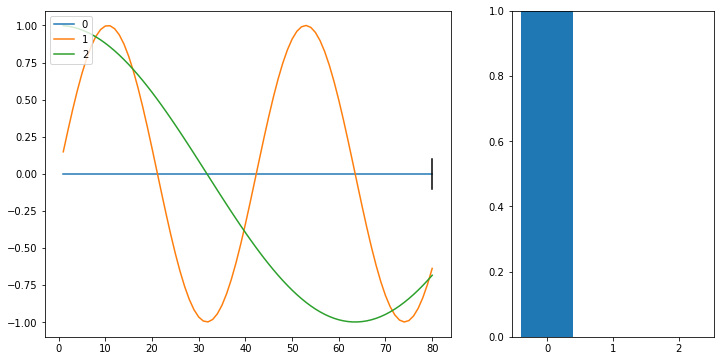

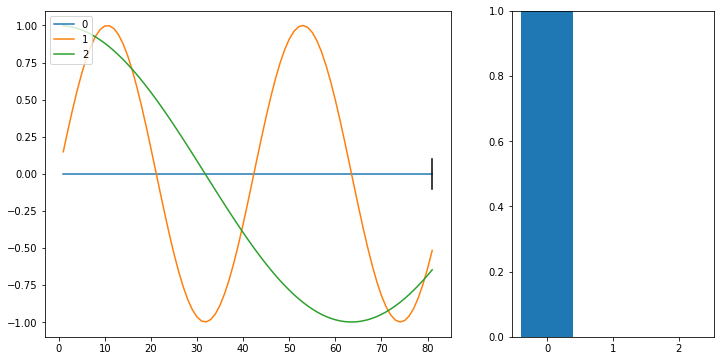

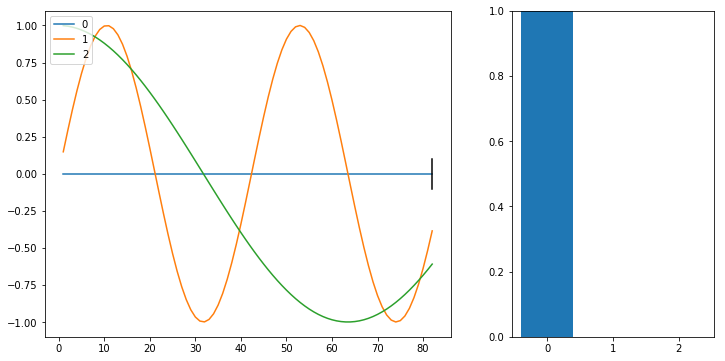

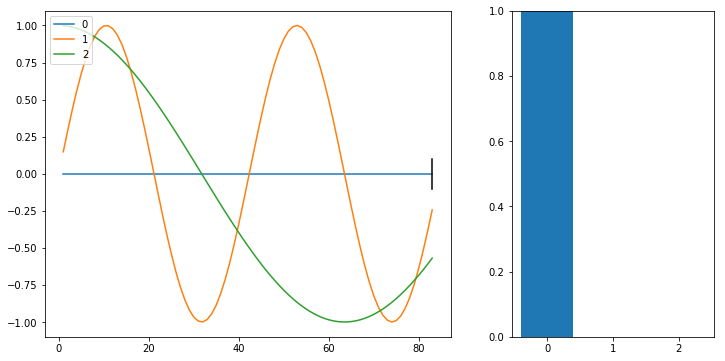

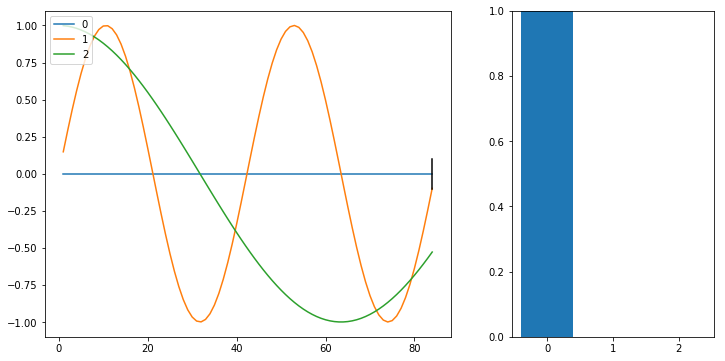

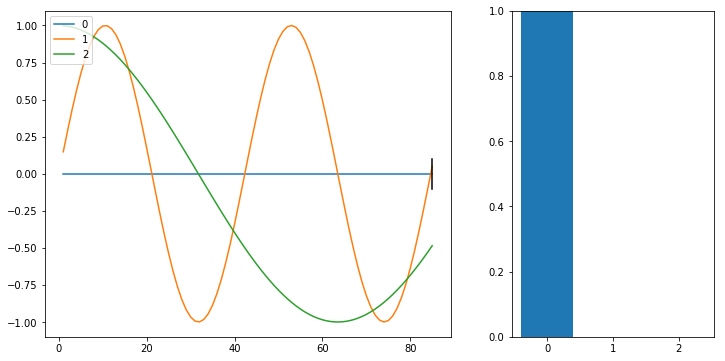

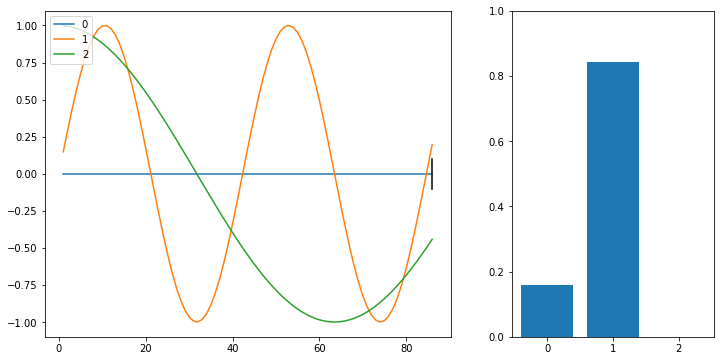

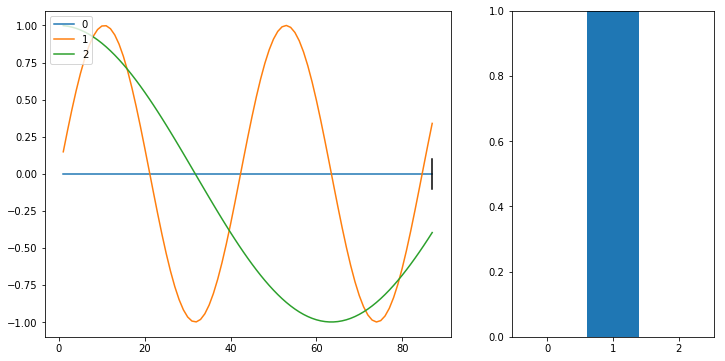

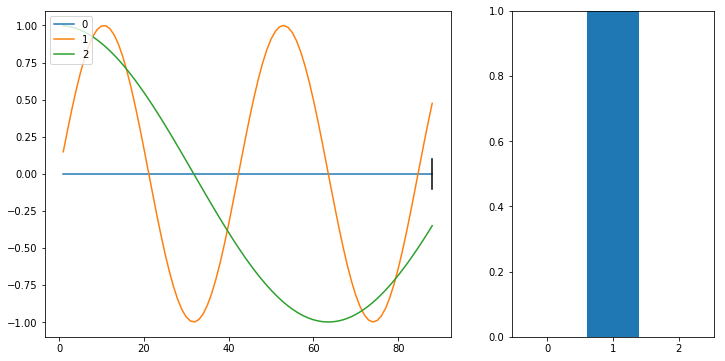

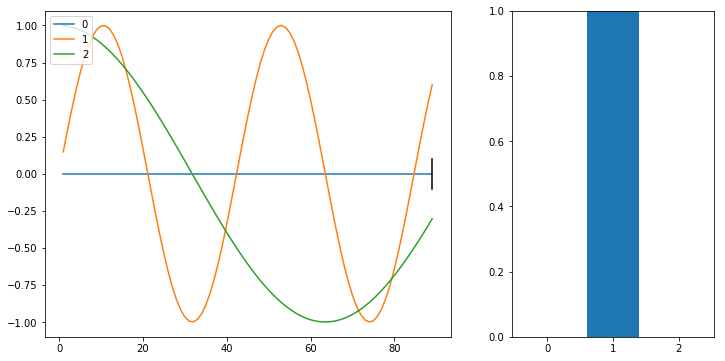

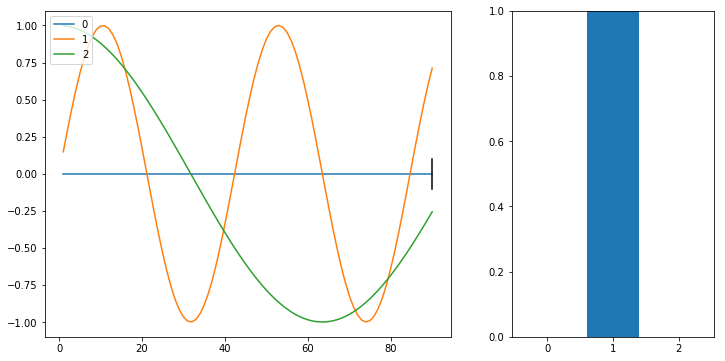

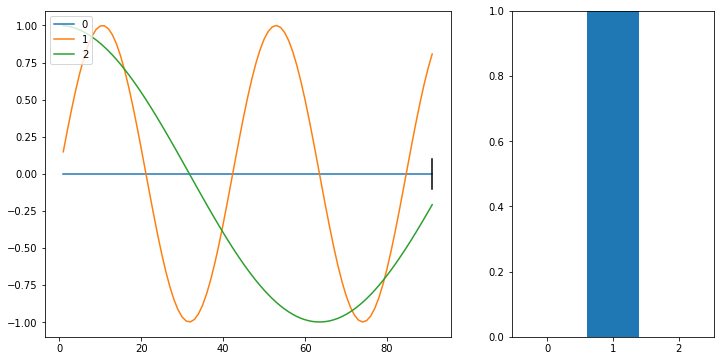

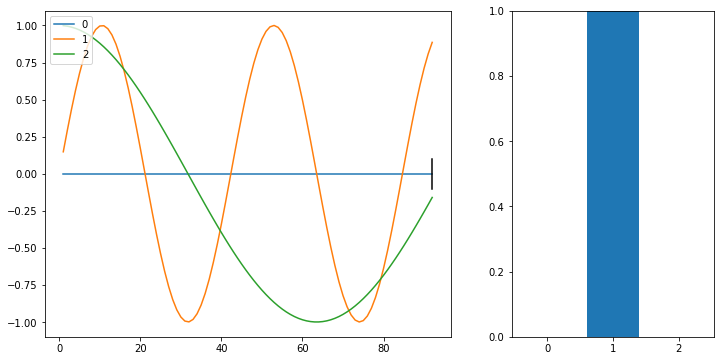

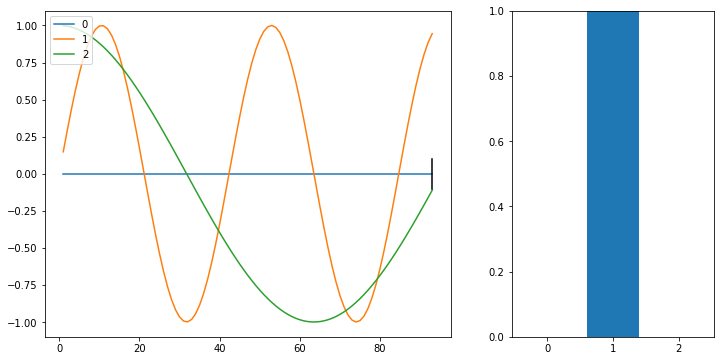

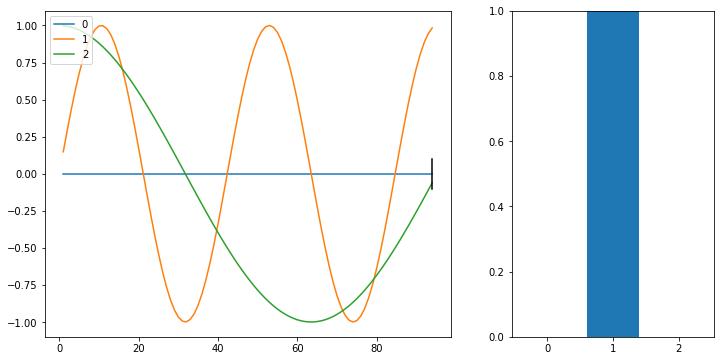

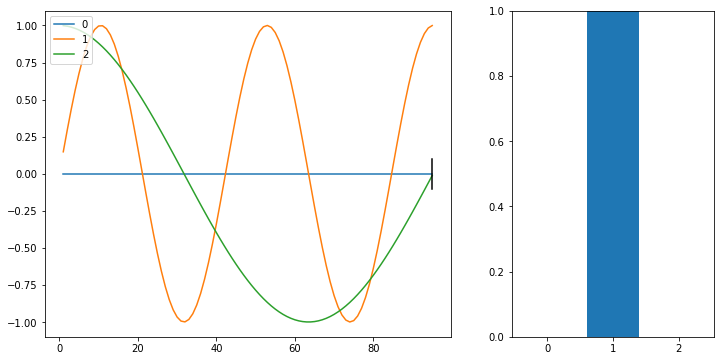

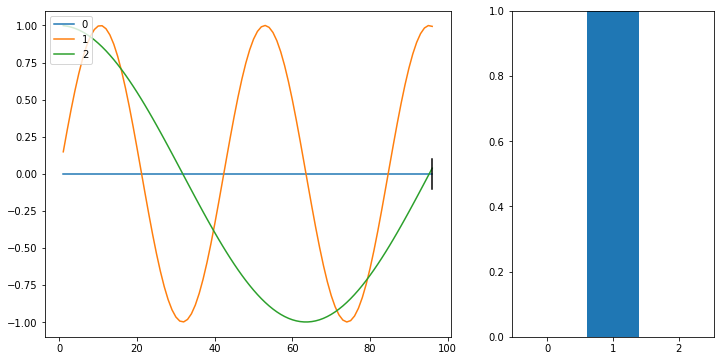

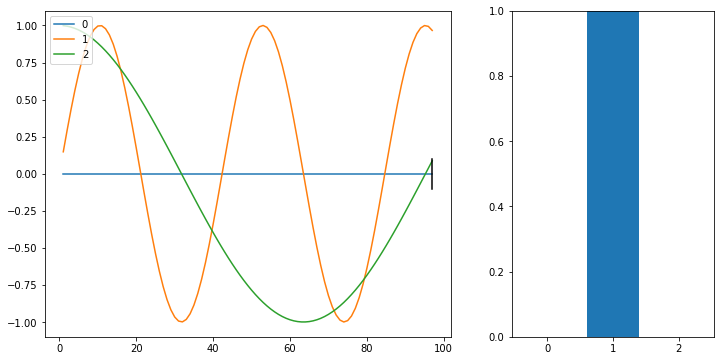

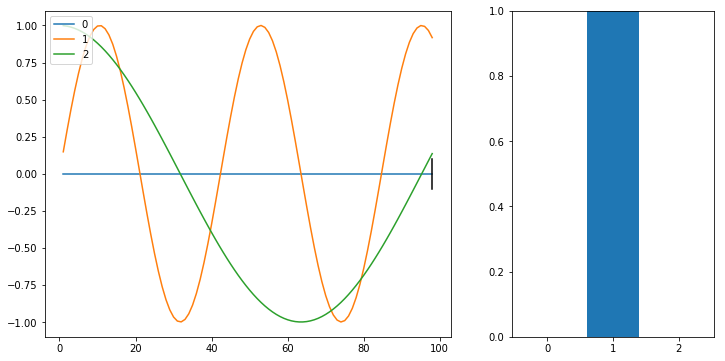

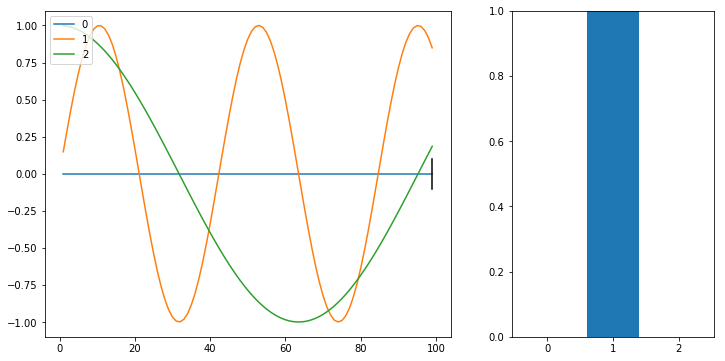

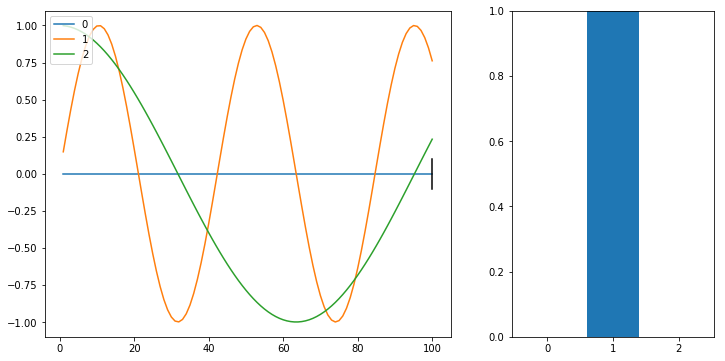

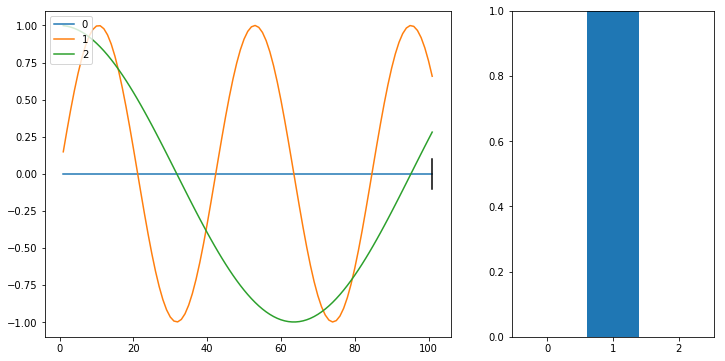

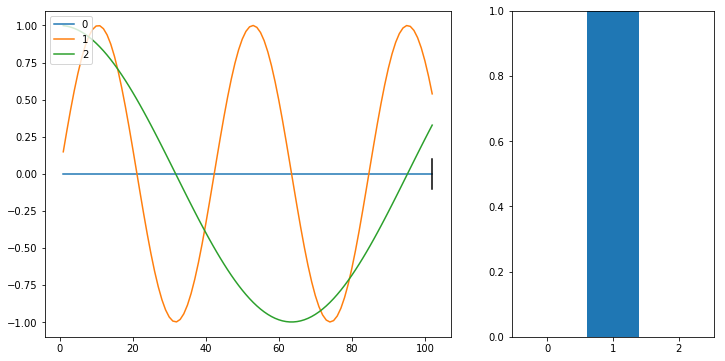

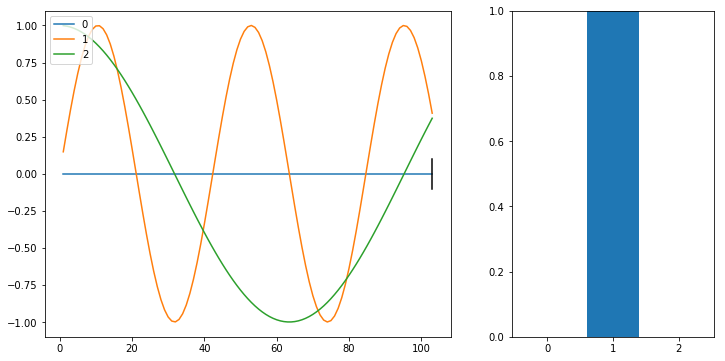

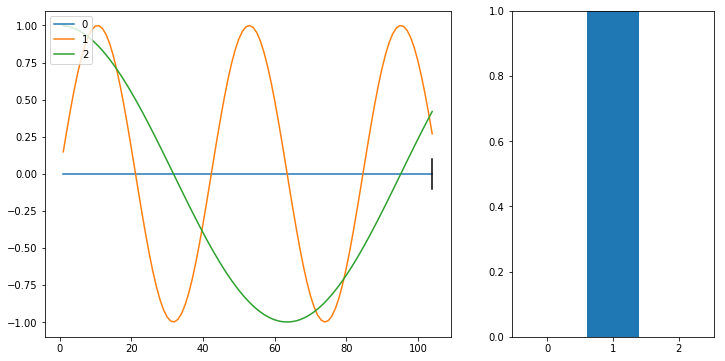

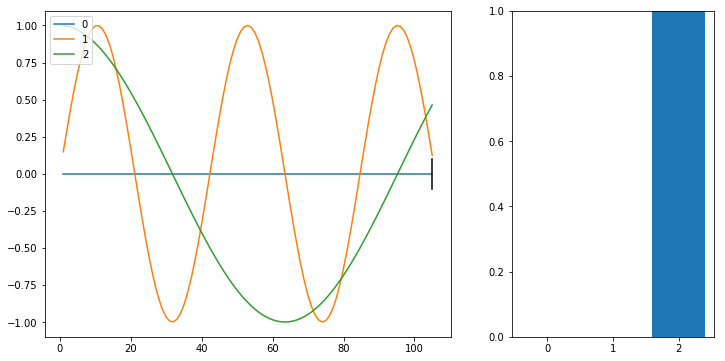

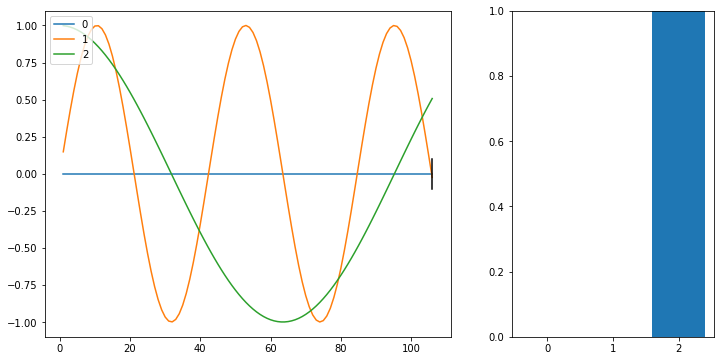

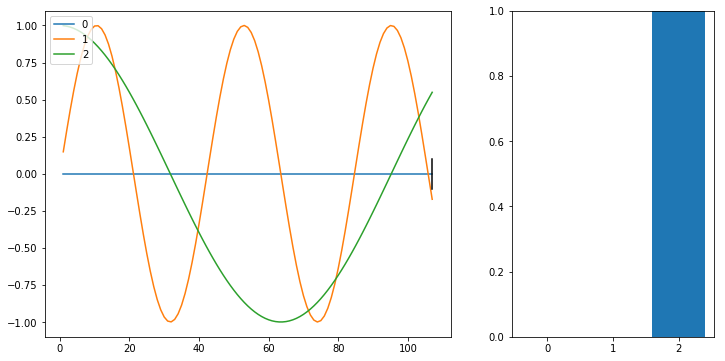

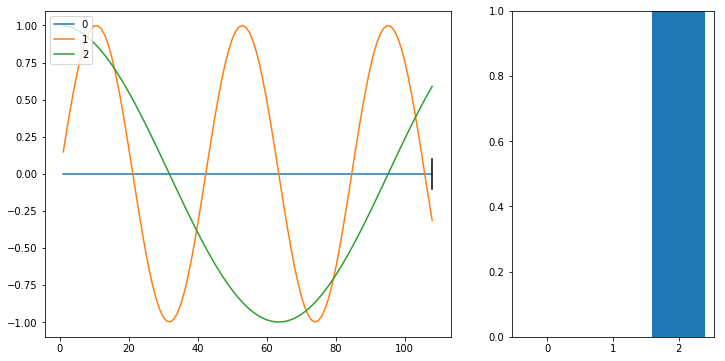

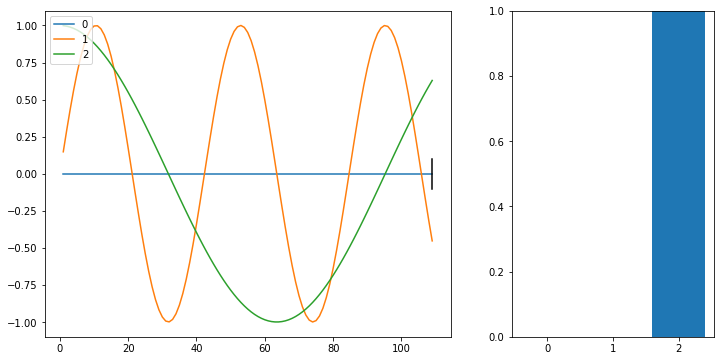

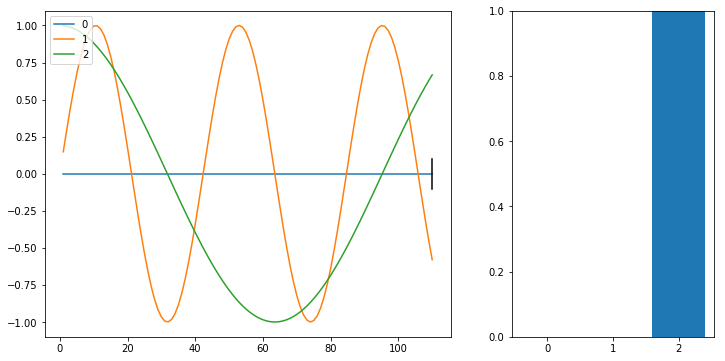

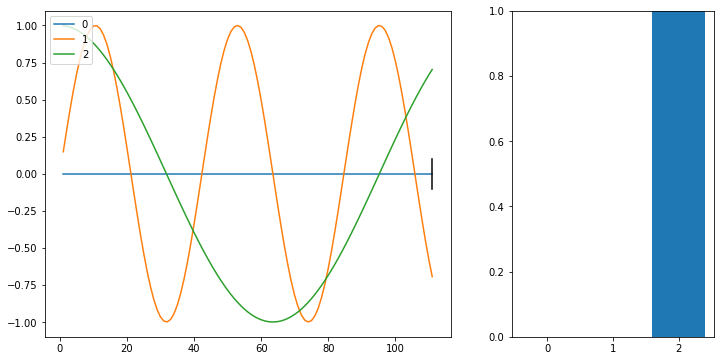

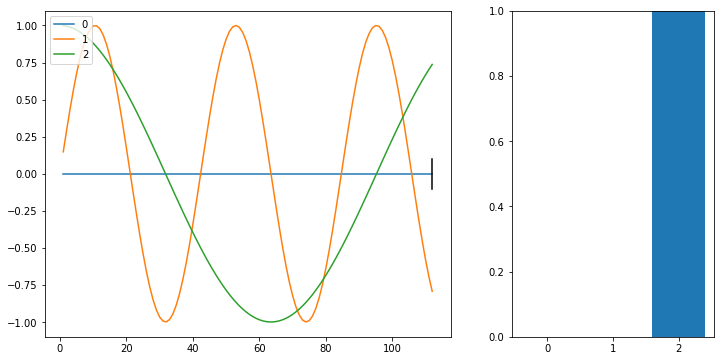

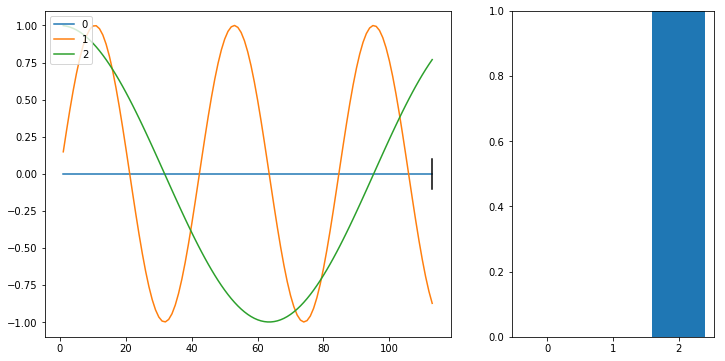

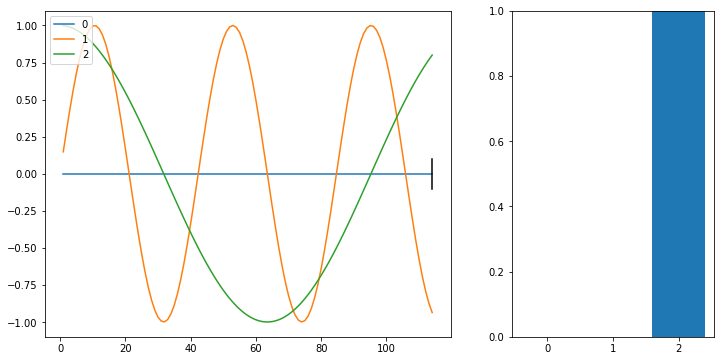

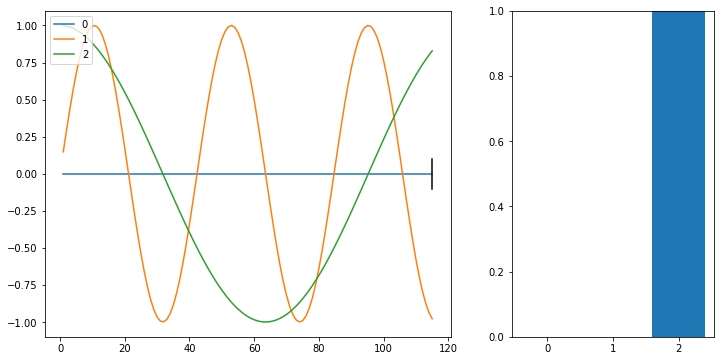

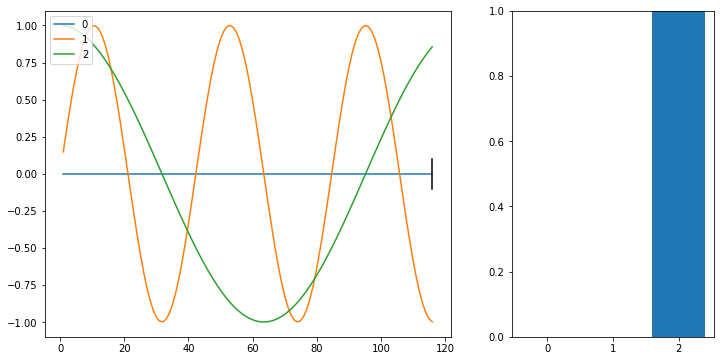

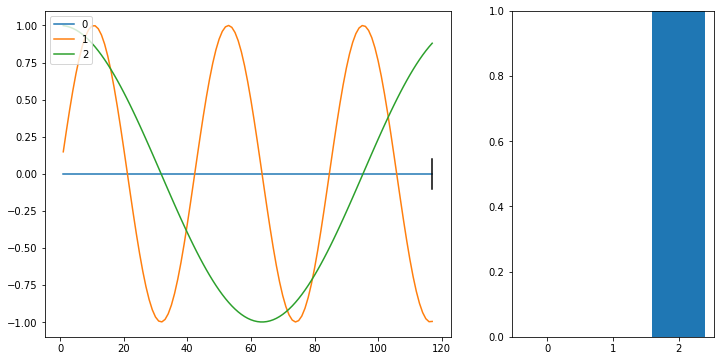

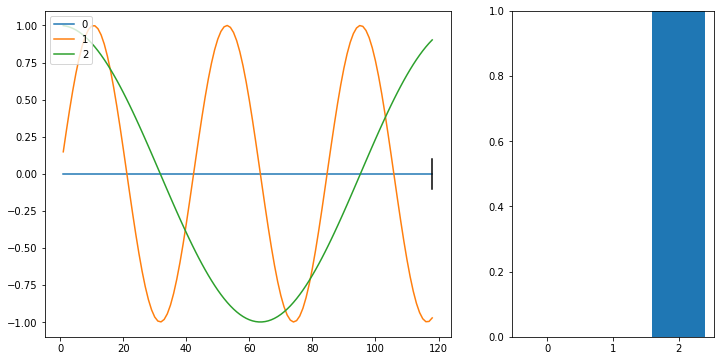

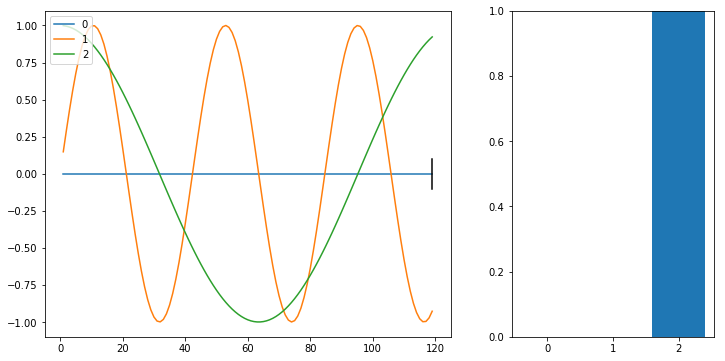

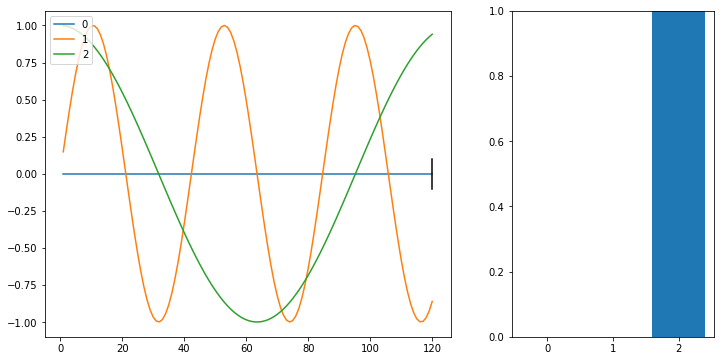

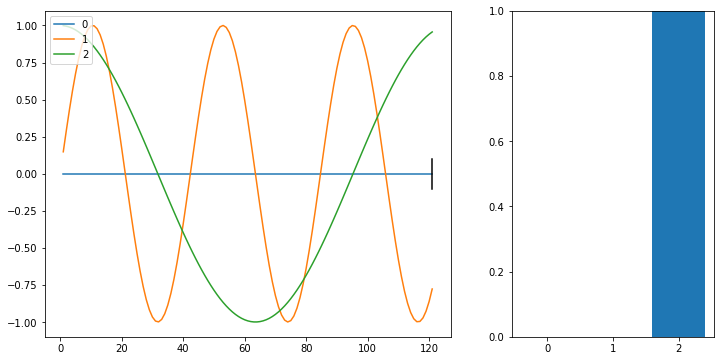

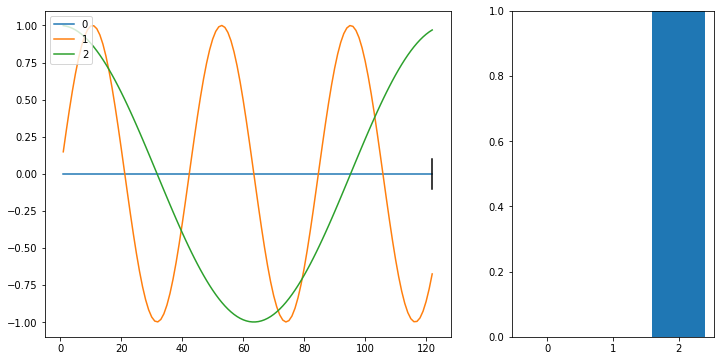

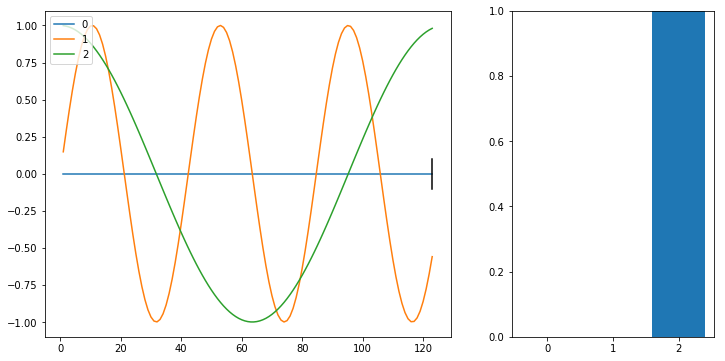

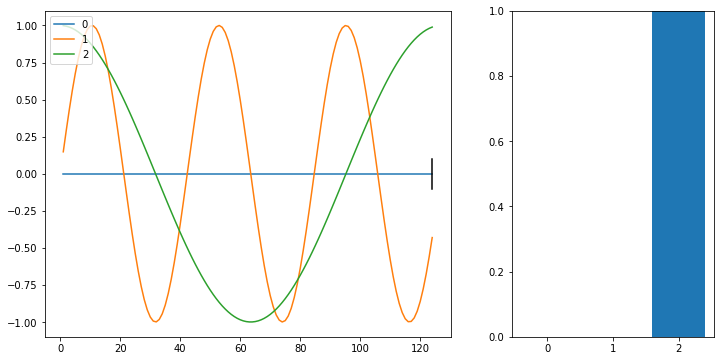

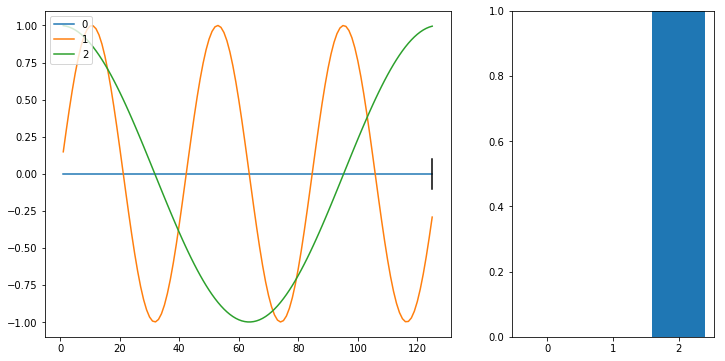

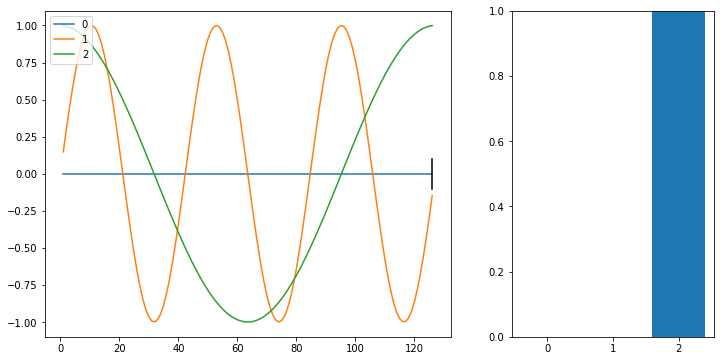

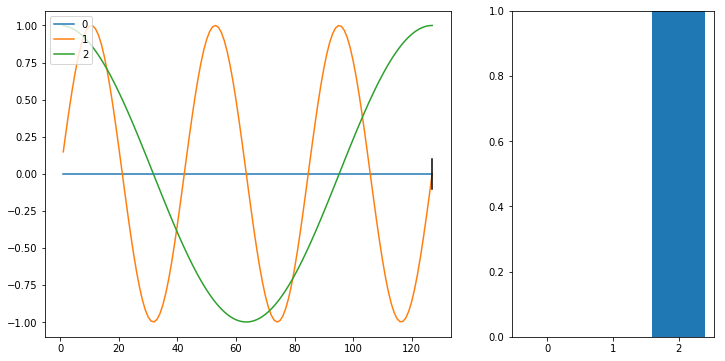

In [61]:
rh = agent.run(env, 1, test_run=True)